In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

from keras.models import Sequential, Model
from keras import regularizers
from keras import constraints
from keras.initializers import Constant
from keras.layers import Input, Conv2D, Conv3D, MaxPooling2D, Dense, Dropout, Activation, concatenate, Lambda, Reshape
from keras.layers.advanced_activations import LeakyReLU


2.1.0
2.3.1


Using TensorFlow backend.


In [3]:
from matplotlib.backends.backend_pdf import PdfPages
pp_predictions = PdfPages('outputPredictions.pdf')

In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    
from pathlib import Path

data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

/kaggle/input
/kaggle/input/abstraction-and-reasoning-challenge
/kaggle/input/abstraction-and-reasoning-challenge/training
/kaggle/input/abstraction-and-reasoning-challenge/evaluation
/kaggle/input/abstraction-and-reasoning-challenge/test


In [5]:
test_tasks = sorted(os.listdir(test_path))
print(test_tasks[:3])

training_tasks = sorted(os.listdir(training_path))
print(training_tasks[:3])

evaluation_tasks = sorted(os.listdir(evaluation_path))
print(evaluation_tasks[:3])

['00576224.json', '009d5c81.json', '00dbd492.json']
['007bbfb7.json', '00d62c1b.json', '017c7c7b.json']
['00576224.json', '009d5c81.json', '00dbd492.json']


In [6]:
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='output_id')
display(submission.head())

output
output_id                                                    
00576224_0                           |32|78| |32|78| |00|00| 
009d5c81_0  |00000000000000|00000888888888|00000800080808|...
00dbd492_0  |00000000000222220000|02222222220200020000|020...
03560426_0  |0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0  |000000000020000000080000000000|00000000002220...

In [7]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [8]:
def isShapeConstant(task):
    isConst = True
    for i in range(len(task["train"])):
        iShape = np.array(task["train"][i]["input"]).shape
        oShape = np.array(task["train"][i]["output"]).shape
        if iShape != oShape:
            isConst = False
            
    #for i in range(len(task["test"])):
    #    iShape = np.array(task["test"][i]["input"]).shape
    #    oShape = np.array(task["test"][i]["output"]).shape
    #    if iShape != oShape:
    #        isConst = False
            
    return isConst

def isInputUnchanged(task):
    res = False
    if isShapeConstant(task):
        res = True
        for i in range(len(task["train"])):
            if not np.all(np.sqrt(np.array(task["train"][i]["input"])*np.array(task["train"][i]["output"])) == np.array(task["train"][i]["input"])):
                res = False
        for i in range(len(task["test"])):
            if not np.all(np.sqrt(np.array(task["test"][i]["input"])*np.array(task["test"][i]["output"])) == np.array(task["test"][i]["input"])):
                res = False
    return res

def isUsingSameColors(task):
    res = True
    
    for i in range(len(task["train"])):
        if not np.all(np.unique(np.array(task["train"][i]["input"])) == np.unique(np.array(task["train"][i]["output"]))):
            res = False
                                                                           
    for i in range(len(task["test"])):
        if not np.all(np.unique(np.array(task["test"][i]["input"])) == np.unique(np.array(task["test"][i]["output"]))):
            res = False
            
    return res

In [9]:
# nColors, dont count black
def expandColors(m,nColors):
    res = []
    for i in range(nColors):
        res.append((m == i+1).astype(int))
    return res

def reduceColors(m):
    res = np.zeros(m[0].shape)
    xs = []
    for i,x in enumerate(m):
        xs.append((i+1)*x)
    res = np.amax(np.array(xs), axis=0)
    return res

In [10]:
from __future__ import absolute_import
import keras.backend as K


def round_through(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    '''
    rounded = K.round(x)
    return x + K.stop_gradient(rounded - x)


def _hard_sigmoid(x):
    '''Hard sigmoid different from the more conventional form (see definition of K.hard_sigmoid).
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    x = (0.5 * x) + 0.5
    return K.clip(x, 0, 1)


def binary_sigmoid(x):
    '''Binary hard sigmoid for training binarized neural network.
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    return round_through(_hard_sigmoid(x))


def binary_tanh(x):
    '''Binary hard sigmoid for training binarized neural network.
     The neurons' activations binarization function
     It behaves like the sign function during forward propagation
     And like:
        hard_tanh(x) = 2 * _hard_sigmoid(x) - 1 
        clear gradient when |x| > 1 during back propagation
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    return 2 * round_through(_hard_sigmoid(x)) - 1


def binarize(W, H=1):
    '''The weights' binarization function, 
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    # [-H, H] -> -H or H
    Wb = H * binary_tanh(W / H)
    return Wb


def _mean_abs(x, axis=None, keepdims=False):
    return K.stop_gradient(K.mean(K.abs(x), axis=axis, keepdims=keepdims))

    
def xnorize(W, H=1., axis=None, keepdims=False):
    Wb = binarize(W, H)
    Wa = _mean_abs(W, axis, keepdims)
    
    return Wa, Wb

In [11]:
# -*- coding: utf-8 -*-
import numpy as np

from keras import backend as K

from keras.layers import InputSpec, Layer, Dense, Conv2D
from keras import constraints
from keras import initializers


class Clip(constraints.Constraint):
    def __init__(self, min_value, max_value=None):
        self.min_value = min_value
        self.max_value = max_value
        if not self.max_value:
            self.max_value = -self.min_value
        if self.min_value > self.max_value:
            self.min_value, self.max_value = self.max_value, self.min_value

    def __call__(self, p):
        return K.clip(p, self.min_value, self.max_value)

    def get_config(self):
        return {"min_value": self.min_value,
                "max_value": self.max_value}


class BinaryDense(Dense):
    ''' Binarized Dense layer
    References: 
    "BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1" [http://arxiv.org/abs/1602.02830]
    '''
    def __init__(self, units, H=1., kernel_lr_multiplier='Glorot', bias_lr_multiplier=None, **kwargs):
        super(BinaryDense, self).__init__(units, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
        super(BinaryDense, self).__init__(units, **kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[1]

        if self.H == 'Glorot':
            self.H = np.float32(np.sqrt(1.5 / (input_dim + self.units)))
            #print('Glorot H: {}'.format(self.H))
        if self.kernel_lr_multiplier == 'Glorot':
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5 / (input_dim + self.units)))
            #print('Glorot learning rate multiplier: {}'.format(self.kernel_lr_multiplier))
            
        self.kernel_constraint = Clip(-self.H, self.H)
        self.kernel_initializer = initializers.RandomUniform(-self.H, self.H)
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                     initializer=self.kernel_initializer,
                                     name='kernel',
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight(shape=(self.output_dim,),
                                     initializer=self.bias_initializer,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)
        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True


    def call(self, inputs):
        binary_kernel = binarize(self.kernel, H=self.H)
        output = K.dot(inputs, binary_kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(BinaryDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class BinaryConv2D(Conv2D):
    '''Binarized Convolution2D layer
    References: 
    "BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1" [http://arxiv.org/abs/1602.02830]
    '''
    def __init__(self, filters, kernel_lr_multiplier='Glorot', 
                 bias_lr_multiplier=None, H=1., **kwargs):
        super(BinaryConv2D, self).__init__(filters, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1 
        if input_shape[channel_axis] is None:
                raise ValueError('The channel dimension of the inputs '
                                 'should be defined. Found `None`.')

        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
            
        base = self.kernel_size[0] * self.kernel_size[1]
        if self.H == 'Glorot':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.H = np.float32(np.sqrt(1.5 / (nb_input + nb_output)))
            #print('Glorot H: {}'.format(self.H))
            
        if self.kernel_lr_multiplier == 'Glorot':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5/ (nb_input + nb_output)))
            #print('Glorot learning rate multiplier: {}'.format(self.lr_multiplier))

        self.kernel_constraint = Clip(-self.H, self.H)
        self.kernel_initializer = initializers.RandomUniform(-self.H, self.H)
        self.kernel = self.add_weight(shape=kernel_shape,
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight((self.output_dim,),
                                     initializer=self.bias_initializers,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)

        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        binary_kernel = binarize(self.kernel, H=self.H) 
        outputs = K.conv2d(
            inputs,
            binary_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(BinaryConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# Aliases

BinaryConvolution2D = BinaryConv2D

### Rewriting Binary Network from (-1,1) to (0,1)

In [12]:
from __future__ import absolute_import
import keras.backend as K


def round_through(x):
    '''Element-wise rounding to the closest integer with full gradient propagation.
    A trick from [Sergey Ioffe](http://stackoverflow.com/a/36480182)
    '''
    rounded = K.round(x)
    return x + K.stop_gradient(rounded - x)


def _hard_sigmoid(x):
    '''Hard sigmoid different from the more conventional form (see definition of K.hard_sigmoid).
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    #x = (0.5 * x) + 0.5
    return K.clip(x, 0, 1)


def binary_sigmoid(x):
    '''Binary hard sigmoid for training binarized neural network.
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    return round_through(_hard_sigmoid(x))


def binary_tanh(x):
    '''Binary hard sigmoid for training binarized neural network.
     The neurons' activations binarization function
     It behaves like the sign function during forward propagation
     And like:
        hard_tanh(x) = 2 * _hard_sigmoid(x) - 1 
        clear gradient when |x| > 1 during back propagation
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    #return round_through(_hard_sigmoid(x))
    return round_through(keras.activations.sigmoid(x*2-1))


def binarize(W, H=1):
    '''The weights' binarization function, 
    # Reference:
    - [BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1, Courbariaux et al. 2016](http://arxiv.org/abs/1602.02830}
    '''
    # [-H, H] -> -H or H
    Wb = H * binary_tanh(W / H)
    return Wb


def _mean_abs(x, axis=None, keepdims=False):
    return K.stop_gradient(K.mean(K.abs(x), axis=axis, keepdims=keepdims))

    
def xnorize(W, H=1., axis=None, keepdims=False):
    Wb = binarize(W, H)
    Wa = _mean_abs(W, axis, keepdims)
    
    return Wa, Wb

In [13]:
# -*- coding: utf-8 -*-
import numpy as np

from keras import backend as K

from keras.layers import InputSpec, Layer, Dense, Conv2D
from keras import constraints
from keras import initializers


class Clip(constraints.Constraint):
    def __init__(self, min_value, max_value=None):
        self.min_value = min_value
        self.max_value = max_value
        if not self.max_value:
            self.max_value = -self.min_value
        if self.min_value > self.max_value:
            self.min_value, self.max_value = self.max_value, self.min_value

    def __call__(self, p):
        return K.clip(p, self.min_value, self.max_value)

    def get_config(self):
        return {"min_value": self.min_value,
                "max_value": self.max_value}


class BinaryDense(Dense):
    ''' Binarized Dense layer
    References: 
    "BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1" [http://arxiv.org/abs/1602.02830]
    '''
    def __init__(self, units, H=1., kernel_lr_multiplier='Glorot', bias_lr_multiplier=None, **kwargs):
        super(BinaryDense, self).__init__(units, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
        super(BinaryDense, self).__init__(units, **kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[1]

        if self.H == 'Glorot':
            self.H = np.float32(np.sqrt(1.5 / (input_dim + self.units)))
            #print('Glorot H: {}'.format(self.H))
        if self.kernel_lr_multiplier == 'Glorot':
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5 / (input_dim + self.units)))
            #print('Glorot learning rate multiplier: {}'.format(self.kernel_lr_multiplier))
            
        self.kernel_constraint = Clip(0, self.H)
        self.kernel_initializer = initializers.RandomUniform(0, self.H)
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                     initializer=self.kernel_initializer,
                                     name='kernel',
                                     regularizer=self.kernel_regularizer,
                                     constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight(shape=(self.output_dim,),
                                     initializer=self.bias_initializer,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)
        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True


    def call(self, inputs):
        binary_kernel = binarize(self.kernel, H=self.H)
        output = K.dot(inputs, binary_kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(BinaryDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class BinaryConv2D(Conv2D):
    '''Binarized Convolution2D layer
    References: 
    "BinaryNet: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1" [http://arxiv.org/abs/1602.02830]
    '''
    def __init__(self, filters, kernel_lr_multiplier='Glorot', 
                 bias_lr_multiplier=None, H=1., **kwargs):
        super(BinaryConv2D, self).__init__(filters, **kwargs)
        self.H = H
        self.kernel_lr_multiplier = kernel_lr_multiplier
        self.bias_lr_multiplier = bias_lr_multiplier
        
        
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1 
        if input_shape[channel_axis] is None:
                raise ValueError('The channel dimension of the inputs '
                                 'should be defined. Found `None`.')

        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
            
        base = self.kernel_size[0] * self.kernel_size[1]
        if self.H == 'Glorot':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.H = np.float32(np.sqrt(1.5 / (nb_input + nb_output)))
            #print('Glorot H: {}'.format(self.H))
            
        if self.kernel_lr_multiplier == 'Glorot':
            nb_input = int(input_dim * base)
            nb_output = int(self.filters * base)
            self.kernel_lr_multiplier = np.float32(1. / np.sqrt(1.5/ (nb_input + nb_output)))
            #print('Glorot learning rate multiplier: {}'.format(self.lr_multiplier))

        self.kernel_constraint = Clip(0, self.H)
        self.kernel_initializer = initializers.RandomUniform(0, self.H)
        self.kernel = self.add_weight(shape=kernel_shape,
                                 initializer=self.kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        if self.use_bias:
            self.lr_multipliers = [self.kernel_lr_multiplier, self.bias_lr_multiplier]
            self.bias = self.add_weight((self.output_dim,),
                                     initializer=self.bias_initializers,
                                     name='bias',
                                     regularizer=self.bias_regularizer,
                                     constraint=self.bias_constraint)

        else:
            self.lr_multipliers = [self.kernel_lr_multiplier]
            self.bias = None

        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        binary_kernel = binarize(self.kernel, H=self.H) 
        outputs = K.conv2d(
            inputs,
            binary_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
        
    def get_config(self):
        config = {'H': self.H,
                  'kernel_lr_multiplier': self.kernel_lr_multiplier,
                  'bias_lr_multiplier': self.bias_lr_multiplier}
        base_config = super(BinaryConv2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


# Aliases

BinaryConvolution2D = BinaryConv2D

In [ ]:
def mse_mask(y_true, y_pred):
    mask = y_true != -1

    return keras.losses.mean_squared_error(tf.boolean_mask(y_true, mask), tf.boolean_mask(y_pred, mask))

In [ ]:
class MyCallback(keras.callbacks.Callback):
    prev = None
    
    def on_epoch_end(self, epoch, logs={}):
        x_train = self.validation_data[0]
        y_train = self.validation_data[1]
        #x_test = self.validation_data[2]
        y_pred = np.round(self.model.predict(x_train, verbose=0)).astype(int)

        x = np.swapaxes(np.array(x_train), 1, 3)
        x = np.array([reduceColors(xi) for xi in x])

        y = np.swapaxes(np.array(y_train), 1, 3)
        y = np.array([reduceColors(xi) for xi in y])
        
        pred = np.swapaxes(np.array(y_pred), 1, 3)
        pred = np.array([reduceColors(xi) for xi in pred])
        score = 1 - np.mean(np.clip(np.abs(y-pred),0,1))
        
        #if np.any(self.prev != pred[0]):
            #plt.imshow(pred[0])
            #plt.show()
        
        self.prev = pred[0]
        
        print(np.sum(pred))
        if np.sum(pred) == 0:
            print("All Black")

        print("Training Accuracy: {}".format(score))

In [ ]:
def make_model(input_shape):
    
    inputs = Input(shape=input_shape)
    
    reshapeInp = Reshape([input_shape[0], input_shape[1], 1])
    
    horizontal = BinaryConv2D(filters=100, kernel_size=(1,input_shape[1]*2-1), use_bias=False, padding="same")
    vertical = BinaryConv2D(filters=100, kernel_size=(input_shape[0]*2-1,1), use_bias=False, padding="same")
    quadratic = BinaryConv2D(filters=100, kernel_size=(9,9), use_bias=False, padding="same")
    
    concat = concatenate
    
    colorDecision = Conv2D(filters=100, activation="hard_sigmoid", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), padding="same")
    decision = Conv2D(filters=100, activation="hard_sigmoid", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), padding="same")
    colorFinal = Conv2D(filters=20, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-5), padding="same")
    final = Conv2D(filters=10, activation="tanh", kernel_size=(1,1), padding="same")
    
    inp = []
    hor = []
    vert = []
    color = []

    ## Generating features from one single color
    for i in range(input_shape[2]):
        inp = Lambda(lambda x: x[:,:,:,i])(inputs)       
        inp = reshapeInp(inp)
        
        hor = horizontal(inp)
        vert = vertical(inp)
        #quad = quadratic(inp)
        
        color.append(concat([hor, vert]))#, quad]))
        
        color[i] = colorDecision(color[i])
        color[i] = colorFinal(color[i])   
     
    ## 
    outs = concatenate(color, axis=3)
    outs = decision(outs)
    outs = final(outs) # this is basically a color swappper and maps with tanh to output space
    
    #outs = out[0]
    
    model = Model(inputs=inputs, outputs=outs)
    return model


In [ ]:
def make_model2(input_shape):
    
    inputs = Input(shape=input_shape)
    
    reshapeInp = Reshape([input_shape[0], input_shape[1], 1])
    
    horizontal = BinaryConv2D(filters=5, kernel_size=(1,input_shape[1]*2-1), use_bias=False, padding="same")
    vertical = BinaryConv2D(filters=5, kernel_size=(input_shape[0]*2-1,1), use_bias=False, padding="same")
    quadratic = BinaryConv2D(filters=10, kernel_size=(9,9), use_bias=False, padding="same")
    
    concat = concatenate
    
    colorDecision = Conv2D(filters=20, activation="hard_sigmoid", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-5), padding="same")
    inpDecision = Conv2D(filters=20, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-5), padding="same")
    decision = Conv2D(filters=20, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-5), padding="same")
    
    colorFinal = Conv2D(filters=1, activation="hard_sigmoid", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-5), padding="same")
    inpFinal = Conv2D(filters=1, activation="hard_sigmoid", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-5), padding="same")
    final = Conv2D(filters=10, activation="tanh", kernel_size=(1,1), padding="same")
    
    inp = []
    hor = []
    vert = []
    color = []
    inputColor = []

    for i in range(input_shape[2]):
        for j in range(input_shape[2]):
            inp = Lambda(lambda x: x[:,:,:,j])(inputs)       
            inp = reshapeInp(inp)
        
            hor = horizontal(inp)
            vert = vertical(inp)
            quad = quadratic(inp)
            thisColor = concat([hor, vert, quad])
            thisColor = inpDecision(thisColor)
            thisColor = inpFinal(thisColor)
            inputColor.append(thisColor)
        
        thisOutColor = concatenate(inputColor, axis=3)
        color.append(colorDecision(thisOutColor))
        color[i] = colorFinal(color[i])   
    
    outs = concatenate(color, axis=3)
    #outs = decision(outs)
    outs = final(outs)
    
    #outs = out[0]
    
    model = Model(inputs=inputs, outputs=outs)
    return model


In [ ]:
def runModel(model, inputData, outputData, epochs):
    EPOCHS = epochs
    INIT_LR = 0.05

    def lr_scheduler(epoch):
        return INIT_LR * 0.98 ** epoch

    #model = make_model(np.array(data["trainVal"])[0,:,:,:].shape)
    #model.summary()

    model.compile(
        #loss='categorical_crossentropy',
        loss=mse_mask,
        optimizer=keras.optimizers.adam(learning_rate=INIT_LR),
        metrics=['accuracy']
    )

    history = model.fit(
        np.array(inputData), np.array(outputData),
        validation_data = [np.array(inputData), np.array(outputData)],
        batch_size=len(inputData),
        epochs=EPOCHS,
        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler),
                  MyCallback()]
    )
    
    return model, history

In [ ]:
pp_predictions = PdfPages('outputPredictions.pdf')

In [ ]:
maxSizeX = 30
maxSizeY = 30

doPadding = True
EPOCHS = 100

countSuccess = 0

predictions = []

dataset = "training"

taskFilenames = []
taskPath = []

if dataset == "training":
    taskPath = training_path
    taskFilenames = training_tasks
if dataset == "evaluation":
    taskPath = evaluation_path
    taskFilenames = evaluation_tasks
if dataset == "test":
    taskPath = test_path
    taskFilenames = test_tasks

for ci, fn in enumerate(taskFilenames):
    task_file = str(taskPath / fn)

    if (dataset != "test") and ci > 10:
        break

    with open(task_file, 'r') as f:
        task = json.load(f)
    
    n_train_pairs = len(task['train'])
    n_test_pairs = len(task['test'])
    prediction = np.array([[[0,0],[0,0]]])
    if(isShapeConstant(task)):
        tf.keras.backend.clear_session()

        inputTrain = []
        inputTest = []        
        
        outputTrain = []
        outputTest = []
        
        maxSizeXTrain = np.max(np.array([np.array(x["input"]).shape[0] for x in task["train"]]))
        maxSizeYTrain = np.max(np.array([np.array(x["input"]).shape[1] for x in task["train"]]))
        maxSizeXTest = np.max(np.array([np.array(x["input"]).shape[0] for x in task["test"]]))
        maxSizeYTest = np.max(np.array([np.array(x["input"]).shape[1] for x in task["test"]]))
    
        maxSizeX = np.max([maxSizeXTrain, maxSizeXTest])
        maxSizeY = np.max([maxSizeYTrain, maxSizeYTest])
        
        #print("Padding to maximum sizes: ({},{})".format(maxSizeX, maxSizeY))
        
        #print("Train:")
        for x in task["train"]:
            padded = np.array(x["input"])
            if doPadding:
                padX1 = int(np.floor((maxSizeX-np.array(x["input"]).shape[0])/2))
                padX2 = int(np.ceil((maxSizeX-np.array(x["input"]).shape[0])/2))
                padY1 = int(np.floor((maxSizeY-np.array(x["input"]).shape[1])/2))
                padY2 = int(np.ceil((maxSizeY-np.array(x["input"]).shape[1])/2))
                padded = np.pad(np.array(x["input"]), ((padX1, padX2), (padY1, padY2)), "constant", constant_values=0)
                #print("--> From ({},{})".format(np.array(x["input"]).shape[0],np.array(x["input"]).shape[1]))
            expanded = np.swapaxes(np.array(expandColors(padded, 10)), 0, 2)
            inputTrain.append(expanded)
            
            padded = np.array(x["output"])
            if doPadding:
                padded = np.pad(np.array(x["output"]), ((padX1, padX2), (padY1, padY2)), "constant", constant_values=0)
            #print("--> From ({},{})".format(np.array(x["input"]).shape[0],np.array(x["input"]).shape[1]))
            expanded = np.swapaxes(np.array(expandColors(padded, 10)), 0, 2)            
            outputTrain.append(expanded)
            
            #print(expanded.shape)
            
        #print("Test:")
        for x in task["test"]:
            padded = np.array(x["input"])
            if doPadding:
                padX1 = int(np.floor((maxSizeX-np.array(x["input"]).shape[0])/2))
                padX2 = int(np.ceil((maxSizeX-np.array(x["input"]).shape[0])/2))
                padY1 = int(np.floor((maxSizeY-np.array(x["input"]).shape[1])/2))
                padY2 = int(np.ceil((maxSizeY-np.array(x["input"]).shape[1])/2))
                padded = np.pad(np.array(x["input"]), ((padX1, padX2), (padY1, padY2)), "constant", constant_values=0)
            #print("--> From ({},{})".format(np.array(x["input"]).shape[0],np.array(x["input"]).shape[1]))
        
            expanded = np.swapaxes(np.array(expandColors(padded, 10)), 0, 2)
            inputTest.append(expanded)
            
            if dataset != "test":
                padded = np.array(x["output"])
                if doPadding:    
                    padded = np.pad(np.array(x["output"]), ((padX1, padX2), (padY1, padY2)), "constant", constant_values=0)
                    #print("--> From ({},{})".format(np.array(x["input"]).shape[0],np.array(x["input"]).shape[1]))
                expanded = np.swapaxes(np.array(expandColors(padded, 10)), 0, 2)            
                outputTest.append(expanded)
            
            #print(expanded.shape)
        
        #print("InputTrain shape: ", inputTrain[0].shape)
        #print("of lenght: ", len(inputTrain))
        #print("OutputTrain shape: ", outputTrain[0].shape)
        #print("of lenght: ", len(outputTrain))
        #print("InputTest shape: ", inputTest[0].shape)
        #print("of lenght: ", len(inputTest))
        
        model = make_model(inputTrain[0].shape)
        if ci < 5:
            model.summary()
        model, history = runModel(model, np.array(inputTrain), np.array(outputTrain), EPOCHS)
        prediction = np.round(model.predict(np.array(inputTest))).astype(int)

        
        #print(prediction.shape)
        #print(np.array(outputTest).shape)    
        
        prediction = np.swapaxes(np.array(prediction), 1, 3)
        prediction = np.array([reduceColors(xi) for xi in prediction])
        
        if dataset != "test":
            outputTest = np.swapaxes(np.array(outputTest), 1, 3)
            outputTestRed = np.array([reduceColors(xi) for xi in outputTest])
            inputTest = np.swapaxes(np.array(inputTest), 1, 3)
            inputTestRed = np.array([reduceColors(xi) for xi in inputTest])
        
            outputTrain = np.swapaxes(np.array(outputTrain), 1, 3)
            outputTrainRed = np.array([reduceColors(xi) for xi in outputTrain])
            inputTrain = np.swapaxes(np.array(inputTrain), 1, 3)
            inputTrainRed = np.array([reduceColors(xi) for xi in inputTrain])        
            #print(prediction)
            #print(outputTest)
            diff = prediction - outputTestRed
            loss = np.mean(np.power(diff,2))
            print("Loss: ", loss)
            
            if loss == 0:
                countSuccess += 1
                print("Success!")
            
            cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
             '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
            norm = colors.Normalize(vmin=0, vmax=9)

            fig, axs = plt.subplots(2, 5, figsize=(15,15))

            axs[0][0].imshow(inputTrainRed[0], cmap=cmap, norm=norm)
            axs[0][0].axis('off')
            axs[0][0].set_title('Train Input')

            axs[0][1].imshow(outputTrainRed[0], cmap=cmap, norm=norm)
            axs[0][1].axis('off')
            axs[0][1].set_title('Train Output')

            axs[0][2].imshow(inputTestRed[0], cmap=cmap, norm=norm)
            axs[0][2].axis('off')
            axs[0][2].set_title('Test Input')

            axs[0][3].imshow(outputTestRed[0], cmap=cmap, norm=norm)
            axs[0][3].axis('off')
            axs[0][3].set_title('Test Output')

            axs[0][4].imshow(prediction[0], cmap=cmap, norm=norm)
            axs[0][4].axis('off')
            axs[0][4].set_title('Prediction')
        
            # Plot training & validation accuracy values
            axs[1][0].plot(history.history['accuracy'])
            #axs[1][0].plot(history.history['val_acc'])
            axs[1][0].set_title('Model accuracy')
            #axs[1][0].ylabel('Accuracy')
            #axs[1][0].xlabel('Epoch')
            #axs[1][0].legend(['Train', 'Test'], loc='upper left')

            # Plot training & validation loss values
            axs[1][1].plot(history.history['loss'])
            #axs[1][0].plot(history.history['val_loss'])
            axs[1][1].set_title('Model loss')
            #axs[1][0].ylabel('Loss')
            #axs[1][0].xlabel('Epoch')
            #axs[1][0].legend(['Train', 'Test'], loc='upper left')
            
            plt.tight_layout()
            pp_predictions.savefig()
            plt.show()
        
    predictions.append(prediction[0].tolist())        

In [ ]:
nSkipped = 0
for i, output_id in enumerate(submission.index):
    #if i > 5:
    #    break
    task_id = output_id.split('_')[0]
    pair_id = int(output_id.split('_')[1])
    
    if pair_id > 0:
        nSkipped += 1
        continue
    
    pred_1 = flattener(predictions[i- nSkipped])
    # for the second guess, change all 0s to 5s
    pred_2 = flattener(predictions[i - nSkipped])
    # for the last gues, change everything to 0
    pred_3 = flattener(predictions[i - nSkipped])
    # concatenate and add to the submission output
    pred = pred_1 + ' ' + pred_2 + ' ' + pred_3 + ' ' 
    submission.loc[output_id, 'output'] = pred

submission.to_csv('submission.csv')

In [ ]:
pp_predictions.close()

# New approach: Train on all training images

Then save the weights of the horizontal and vertical layers. Then train on evaluation training set just the decision and final layers

### Reading in the data

In [ ]:
dataset = "training"

taskFilenames = []
taskPath = []

if dataset == "training":
    taskPath = training_path
    taskFilenames = training_tasks
if dataset == "evaluation":
    taskPath = evaluation_path
    taskFilenames = evaluation_tasks
if dataset == "test":
    taskPath = test_path
    taskFilenames = test_tasks

    
inputTrain = []
inputTest = []   

outputTrain = []
outputTest = []
        
        
for ci, fn in enumerate(taskFilenames):
    task_file = str(taskPath / fn)

    if (dataset != "test") and ci > 200:
        break

    with open(task_file, 'r') as f:
        task = json.load(f)
    
    n_train_pairs = len(task['train'])
    n_test_pairs = len(task['test'])
    prediction = np.array([[[0,0],[0,0]]])
    if(isShapeConstant(task)):
        for x in task["train"]:
            inputTrain.append(x["input"])
            outputTrain.append(x["output"])
        for x in task["test"]:
            inputTest.append(x["input"])
            outputTest.append(x["output"])

inputTrain.extend(inputTest)
outputTrain.extend(outputTest)

assert len(inputTrain) == len(outputTrain)

> ### Padding

pad everything to 30x30

In [ ]:
def padding_img(img, sizeX, sizeY, paddedValue=-1):
    padX1 = int(np.floor((maxSizeX-np.array(img).shape[0])/2))
    padX2 = int(np.ceil((maxSizeX-np.array(img).shape[0])/2))
    padY1 = int(np.floor((maxSizeY-np.array(img).shape[1])/2))
    padY2 = int(np.ceil((maxSizeY-np.array(img).shape[1])/2))
    
    paddedImg = np.pad(np.array(img), ((padX1, padX2), (padY1, padY2)), "constant", constant_values=paddedValue)
       
    return paddedImg

In [ ]:
maxSizeX = 30
maxSizeY = 30
_nColors = 10

paddedValue = 0

def preprocess_tasks(tasks, doPadding=True, doExpanding=True, doSwappingAxes=True):
    outputTasks = []
    for x in tasks:
        x = np.array(x)
        if doExpanding:
            x = np.array(expandColors(x, _nColors))
            if doPadding:
                newX = np.zeros([x.shape[0], maxSizeX, maxSizeY])
                for ci, c in enumerate(x):
                    cx = padding_img(c, maxSizeX, maxSizeY, paddedValue=paddedValue)
                    newX[ci] = cx
                x = newX
            if doSwappingAxes:
                x = np.swapaxes(x, 0, 2)
        else:
            if doPadding:
                x = padding_img(x, maxSizeX, maxSizeY, paddedValue=paddedValue)
        outputTasks.append(x)
    return np.stack(outputTasks, axis=0)

In [ ]:
input_preproc  = preprocess_tasks(inputTrain,  doPadding=True, doExpanding=True, doSwappingAxes=True)
output_preproc = preprocess_tasks(outputTrain, doPadding=True, doExpanding=True, doSwappingAxes=True)

In [ ]:
def mse_mask(y_true, y_pred):
    mask = y_true != -1

    return keras.losses.mean_squared_error(y_true, y_pred)

In [ ]:
def l1l2(y_true, y_pred):
    loss = keras.losses.mean_squared_error(y_true, y_pred) + keras.losses.mean_absolute_error(y_true, y_pred)
    return loss

In [ ]:
def expoLoss(y_true, y_pred):
    diff = K.abs(y_true - y_pred)
    exponent = K.exp(diff) - 1
    loss = K.mean(K.square(exponent), axis=-1)
    return loss

In [ ]:
def make_model(input_shape):
    
    inputs = Input(shape=input_shape)
    _nColor = input_shape[2]
    
    reshapeInp = Reshape([input_shape[0], input_shape[1], 1], name="ReshapeForColor")
    
    horizontal = BinaryConv2D(filters=10, kernel_size=(1,input_shape[1]*2-1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="horizontal")
    vertical = BinaryConv2D(filters=10, kernel_size=(input_shape[0]*2-1,1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="vertical")
    quadratic = BinaryConv2D(filters=5, kernel_size=(3,3), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="quadratic")
    quadratic2 = BinaryConv2D(filters=5, kernel_size=(3,3), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="quadratic2")
    quadratic3 = BinaryConv2D(filters=5, kernel_size=(3,3), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="quadratic3")
        
    #colorDecision = BinaryConv2D(filters=10, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), use_bias=False, padding="same", name="colorDecision")
    #colorFinal = Conv2D(filters=1, activation="tanh", kernel_size=(1,1), use_bias=False, kernel_regularizer=regularizers.l1(1e-4), padding="same", name="colorFinal")
    #decision = BinaryConv2D(filters=10, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), use_bias=False, padding="same", name="decision")
    #final = Conv2D(filters=10, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), use_bias=False, padding="same", name="final")
    
    #colorDecision.trainable = False
    
    outColorTools = []
     
    #inpPos = Lambda(lambda x: tf.keras.backend.maximum(x, 0))(inputs)

    ## Generating features from one single color
    for i in range(_nColor): #OutputColors
        #inp = Lambda(lambda x: x[:,:,:,i])(inputs)
        #inp = reshapeInp(inp)
         
        inpColorDecision = BinaryConv2D(filters=_nColors, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same")(inputs)
        inpColorTools = []
        for j in range(_nColor): #Input Colors
            inpColor = Lambda(lambda x: x[:,:,:,j])(inpColorDecision)
            inpColor = reshapeInp(inpColor)        
            # --- Toolbox ---
            hor = horizontal(inpColor)
            vert = vertical(inpColor)
            quad = quadratic(inpColor)
            quad2 = quadratic2(quad)
            quad3 = quadratic3(quad2)

            toolbox = concatenate([hor, vert, quad, quad2, quad3])
            inpColorTools.append(toolbox)
            # ----------------
        inpColorTools = concatenate(inpColorTools)
        
        outColorToolsDecision = Conv2D(filters=10, activation="linear", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same")(inpColorTools)
        outColorToolsDecision = Conv2D(filters=1, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same")(outColorToolsDecision)
        outColorTools.append(outColorToolsDecision)
        #color[i] = colorDecision(color[i])
        #color[i] = colorFinal(color[i])   
     
    ## 
    outs = concatenate(outColorTools, axis=3)
    #outs = decision(outs)
    #outs = final(outs) # this is basically a color swappper and maps with sigmoid to output space
    
    #outs = out[0]
    
    model = Model(inputs=inputs, outputs=outs)
    return model


In [ ]:
def runModel(model, inputData, outputData, epochs):
    EPOCHS = epochs
    INIT_LR = 0.02

    def lr_scheduler(epoch):
        return INIT_LR * 1.0 ** epoch

    #model = make_model(np.array(data["trainVal"])[0,:,:,:].shape)
    #model.summary()

    model.compile(
        #loss='categorical_crossentropy',
        loss=expoLoss,
        #loss="mean_squared_error",
        optimizer=keras.optimizers.adam(learning_rate=INIT_LR),
        metrics=['accuracy']
    )

    #print("Setting weights of colorDecision layer to zero")
    #w = model.get_layer("colorDecision").get_weights()
    #print("Weights shape:", w[0].shape)
    #print("Bias shape:", w[1].shape)
    #wz = np.zeros(w[0].shape)
    #wz[0,0,0,0] = 1
    #w[0] = wz
    #model.get_layer("colorDecision").set_weights(w)
    #w = model.get_layer("colorDecision").get_weights()
    #print(w)
    
    history = model.fit(
        np.array(inputData), np.array(outputData),
        validation_data = [np.array(inputData), np.array(outputData)],
        batch_size=1,
        epochs=EPOCHS,
        callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)]
    )
    
    return model, history

In [ ]:
EPOCHS = 100
start = 0
nTrain = 4

model = make_model(input_preproc[0].shape)
model.summary()

model, history = runModel(model, np.array(input_preproc[start:start+nTrain]), np.array(output_preproc[start:start+nTrain]), EPOCHS)

In [ ]:
predictionRaw = model.predict(np.array(input_preproc[:5]))
print(np.max(predictionRaw))
prediction = np.round(predictionRaw).astype(int)

prediction = np.swapaxes(np.array(prediction), 1, 3)
predictionRaw = np.swapaxes(np.array(predictionRaw), 1, 3)
prediction = np.array([reduceColors(xi) for xi in prediction])

In [ ]:
for c in predictionRaw[4]:
    plt.imshow(c)
    plt.colorbar()
    plt.show()


In [ ]:
input_reduced = np.swapaxes(np.array(input_preproc), 1, 3)
input_reduced = np.array([reduceColors(xi) for xi in input_reduced])

output_reduced = np.swapaxes(np.array(output_preproc), 1, 3)
output_reduced = np.array([reduceColors(xi) for xi in output_reduced])

In [ ]:
for inp, out, pred in zip(input_reduced, output_reduced, prediction):

    cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    axs[0].imshow(inp, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Train Input')

    axs[1].imshow(out, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Train Output')

    axs[2].imshow(pred, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Prediction')
    
    plt.show()


In [ ]:
horizontalNum = 112
verticalNum = 113
quadraticNum = 114

out1Num = 1 + 2
out2Num = 1 + 3
out3Num = 225 + 2
out4Num = 225 + 3

for layerNum, layer in enumerate(model.layers):
    w = layer.get_weights()
    weights = None
    if len(w) > 0:
        weights = w[0]
    else:
        continue

    if len(w) > 1:
        biases = w[1]
        print("Bias {}".format(biases[0]))
    
    if len(weights) > 0:
        
        print(layerNum, weights.shape)
        if layerNum == horizontalNum:
            plt.imshow(weights[0,:,0,:])
            plt.colorbar()
            plt.show()
        if layerNum == verticalNum:
            plt.imshow(weights[:,0,0,:])
            plt.colorbar()
            plt.show()
        if layerNum == quadraticNum:
            for k in range(weights.shape[3]):
                plt.imshow(weights[:,:,0,k])
                plt.colorbar()
                plt.show()
        if layerNum == out1Num or layerNum == out2Num or layerNum == out3Num or layerNum == out4Num:
            plt.imshow(weights[0,0,:,:])
            plt.xlabel("outputColors")
            plt.ylabel("Inputs")
            plt.colorbar()
            plt.show()            

In [ ]:
for layerNum, layer in enumerate(model.layers):
    w = layer.get_weights()
    weights = None
    if len(w) > 0:
        weights = w[0]
    else:
        continue

    if len(w) > 1:
        biases = w[1]
        print("Bias {}".format(biases[0]))
    
    if len(weights) > 0:
        if layerNum == 12:
            weights = np.zeros(weights.shape)
            weights[:,int((weights.shape[1]+1.)/2.),:,:] = 1
            w[0] = weights
            layer.set_weights(w)
        if layerNum == 24:
            weights = np.zeros(weights.shape)
            weights[:,:,0,:] = 1
            w[0] = weights
            layer.set_weights(w)
        if layerNum == 26:
            weights = np.zeros(weights.shape)
            weights[:,:,2,:] = 1
            w[0] = weights
            layer.set_weights(w)
        if layerNum == 27:
            weights = np.zeros(weights.shape)
            weights[:,:,:,2] = 1
            w[0] = weights
            layer.set_weights(w)

In [ ]:
cmapList = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']

for i, c in enumerate(cmapList):
    plt.plot(i,1, "*", color=c)
plt.show()

### Adam with different LR for different Layers

In [14]:
from keras.legacy import interfaces
import keras.backend as K
from keras.optimizers import Optimizer

class M_Nadam(Optimizer):

    def __init__(self, learning_rate=0.002, beta_1=0.9, beta_2=0.999,
                 epsilon=None, schedule_decay=0.004, multipliers=None,**kwargs):
        super(M_Nadam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.m_schedule = K.variable(1., name='m_schedule')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.schedule_decay = schedule_decay

        if multipliers is None:
            multipliers = {}
        self.lr_multipliers = multipliers

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        t = K.cast(self.iterations, K.floatx()) + 1

        # Due to the recommendations in [2], i.e. warming momentum schedule
        momentum_cache_t = self.beta_1 * (
            1. - 0.5 * (K.pow(K.cast_to_floatx(0.96), t * self.schedule_decay)))
        momentum_cache_t_1 = self.beta_1 * (
            1. - 0.5 * (K.pow(K.cast_to_floatx(0.96), (t + 1) * self.schedule_decay)))
        m_schedule_new = self.m_schedule * momentum_cache_t
        m_schedule_next = self.m_schedule * momentum_cache_t * momentum_cache_t_1
        self.updates.append((self.m_schedule, m_schedule_new))

        shapes = [K.int_shape(p) for p in params]
        ms = [K.zeros(shape) for shape in shapes]
        vs = [K.zeros(shape) for shape in shapes]

        self.weights = [self.iterations] + ms + vs

        learning_rate = self.learning_rate

        for p, g, m, v in zip(params, grads, ms, vs):

            matched_layer = [x for x in self.lr_multipliers.keys() if x in p.name]
            if matched_layer:
                new_lr = learning_rate * self.lr_multipliers[matched_layer[0]]
            else:
                new_lr = learning_rate

            # the following equations given in [1]
            g_prime = g / (1. - m_schedule_new)
            m_t = self.beta_1 * m + (1. - self.beta_1) * g
            m_t_prime = m_t / (1. - m_schedule_next)
            v_t = self.beta_2 * v + (1. - self.beta_2) * K.square(g)
            v_t_prime = v_t / (1. - K.pow(self.beta_2, t))
            m_t_bar = (1. - momentum_cache_t) * g_prime + momentum_cache_t_1 * m_t_prime

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))

            p_t = p - new_lr * m_t_bar / (K.sqrt(v_t_prime) + self.epsilon)
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))

        return self.updates

    def get_config(self):
        config = {'learning_rate': float(K.get_value(self.learning_rate)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'epsilon': self.epsilon,
                  'schedule_decay': self.schedule_decay}
        base_config = super(M_Nadam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class M_Adam(Optimizer):

    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., amsgrad=False, multipliers=None,**kwargs):
        super(M_Adam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad

        if multipliers is None:
            multipliers = {}
        self.lr_multipliers = multipliers

    @interfaces.legacy_get_updates_support
    @K.symbolic
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        learning_rate = self.learning_rate
        if self.initial_decay > 0:
            learning_rate = learning_rate * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = learning_rate * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]        
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):

            matched_layer = [x for x in self.lr_multipliers.keys() if x in p.name]
            if matched_layer:
                new_lr = lr_t * self.lr_multipliers[matched_layer[0]]
            else:
                new_lr = lr_t

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - new_lr * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - new_lr * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'learning_rate': float(K.get_value(self.learning_rate)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad}
        base_config = super(M_Adam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class M_RMSprop(Optimizer):
    def __init__(self, learning_rate=0.001, rho=0.9, epsilon=None, decay=0.,multipliers=None,
                 **kwargs):
        super(M_RMSprop, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.learning_rate = K.variable(learning_rate, name='learning_rate')
            self.rho = K.variable(rho, name='rho')
            self.decay = K.variable(decay, name='decay')
            self.iterations = K.variable(0, dtype='int64', name='iterations')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay

        if multipliers is None:
            multipliers = {}
        self.lr_multipliers = multipliers
    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        accumulators = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = accumulators
        self.updates = [K.update_add(self.iterations, 1)]

        learning_rate = self.learning_rate
        if self.initial_decay > 0:
            learning_rate = learning_rate * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        for p, g, a in zip(params, grads, accumulators):

            matched_layer = [x for x in self.lr_multipliers.keys() if x in p.name]
            if matched_layer:
                new_lr = learning_rate * self.lr_multipliers[matched_layer[0]]
            else:
                new_lr = learning_rate

            # update accumulator
            new_a = self.rho * a + (1. - self.rho) * K.square(g)
            self.updates.append(K.update(a, new_a))
            new_p = p - new_lr * g / (K.sqrt(new_a) + self.epsilon)

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'learning_rate': float(K.get_value(self.learning_rate)),
                  'rho': float(K.get_value(self.rho)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon}
        base_config = super(M_RMSprop, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
dataset = "training"

taskFilenames = []
taskPath = []

if dataset == "training":
    taskPath = training_path
    taskFilenames = training_tasks
if dataset == "evaluation":
    taskPath = evaluation_path
    taskFilenames = evaluation_tasks
if dataset == "test":
    taskPath = test_path
    taskFilenames = test_tasks

    

trainTasks = []
testTasks = []
        
for ci, fn in enumerate(taskFilenames):
    task_file = str(taskPath / fn)

    if (dataset != "test") and ci > 400:
        break

    with open(task_file, 'r') as f:
        task = json.load(f)
    
    inputTrain = []
    inputTest = []   

    outputTrain = []
    outputTest = []
    
    n_train_pairs = len(task['train'])
    n_test_pairs = len(task['test'])
    prediction = np.array([[[0,0],[0,0]]])
    if(isShapeConstant(task)):
        for x in task["train"]:
            inputTrain.append(np.array(x["input"]))
            outputTrain.append(np.array(x["output"]))
        for x in task["test"]:
            inputTest.append(np.array(x["input"]))
            outputTest.append(np.array(x["output"]))

        trainTasks.append(dict({"input": inputTrain, "output": outputTrain}))
        testTasks.append(dict({"input": inputTest, "output": outputTest}))

    


In [16]:
trainTasks[0]["input"]

[array([[0, 0, 0, 0, 0, 0],
        [0, 0, 3, 0, 0, 0],
        [0, 3, 0, 3, 0, 0],
        [0, 0, 3, 0, 3, 0],
        [0, 0, 0, 3, 0, 0],
        [0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 3, 0, 3, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 0, 3, 0, 0, 0, 0],
        [0, 0, 3, 0, 0, 0, 3, 0, 0, 0],
        [0, 0, 0, 0, 0, 3, 0, 3, 0, 0],
        [0, 0, 0, 3, 0, 3, 3, 0, 0, 0],
        [0, 0, 3, 3, 3, 0, 0, 0, 0, 0],
        [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 3, 0, 0, 0, 0, 0],
        [0, 3, 3, 0, 3, 3, 0, 3, 0, 0],
        [3, 0, 0, 3, 0, 0, 3, 0, 3, 0],
        [0, 0, 0, 3, 0, 0, 3, 3, 0, 0],
        [0, 0, 0, 3, 0, 0, 3, 0, 0, 0],
        [0, 0, 0, 3, 0, 0, 3, 0, 0, 0],
        [0, 0, 0, 0, 3, 3, 0, 3, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0,

In [17]:
def padding_img(img, sizeX, sizeY, paddedValue=-1):
    padX1 = int(np.floor((maxSizeX-np.array(img).shape[0])/2))
    padX2 = int(np.ceil((maxSizeX-np.array(img).shape[0])/2))
    padY1 = int(np.floor((maxSizeY-np.array(img).shape[1])/2))
    padY2 = int(np.ceil((maxSizeY-np.array(img).shape[1])/2))
    
    paddedImg = np.pad(np.array(img), ((padX1, padX2), (padY1, padY2)), "constant", constant_values=paddedValue)
       
    return paddedImg

In [18]:
maxSizeX = 30
maxSizeY = 30
_nColors = 10

paddedValue = 0

def preprocess_task(task, doPadding=True, doExpanding=True, doSwappingAxes=True):
    outputTask = None
    if doExpanding:
        outputTask = np.array(expandColors(task, _nColors))
        if doPadding:
            newX = np.zeros([outputTask.shape[0], maxSizeX, maxSizeY])
            for ci, c in enumerate(outputTask):
                cx = padding_img(c, maxSizeX, maxSizeY, paddedValue=paddedValue)
                newX[ci] = cx
            outputTask = newX
        if doSwappingAxes:
            outputTask = np.swapaxes(outputTask, 0, 2)
    else:
        if doPadding:
            outputTask = padding_img(outputTask, maxSizeX, maxSizeY, paddedValue=paddedValue)
    return outputTask

In [19]:
for i, task in enumerate(trainTasks):
    for j, img in enumerate(task["input"]):
        task["input"][j] = preprocess_task(img,  doPadding=True, doExpanding=True, doSwappingAxes=True)
    trainTasks[i]["input"] = np.stack(task["input"], axis=0)
    
    for j, img in enumerate(task["output"]):
        task["output"][j] = preprocess_task(img,  doPadding=True, doExpanding=True, doSwappingAxes=True)
    trainTasks[i]["output"] = np.stack(task["output"], axis=0)

        
for i, task in enumerate(testTasks):
    for j, img in enumerate(task["input"]):
        task["input"][j] = preprocess_task(img,  doPadding=True, doExpanding=True, doSwappingAxes=True)
    testTasks[i]["input"] = np.stack(task["input"], axis=0)
        
    for j, img in enumerate(task["output"]):
        task["output"][j] = preprocess_task(img,  doPadding=True, doExpanding=True, doSwappingAxes=True)
    testTasks[i]["output"] = np.stack(task["output"], axis=0)


In [20]:
def expoLoss(y_true, y_pred):
    diff = K.abs(y_true - y_pred)
    #black = K.abs(K.cast(K.sum(y_true, axis=-1) == 0, "float32") - K.cast(K.sum(y_pred, axis=-1) == 0, "float32"))
    exponent = K.exp(diff) - 1
    #exponentBlack = K.exp(black) - 1
    loss = K.mean(K.pow(exponent, 3))# + K.mean(K.pow(exponentBlack, 3))
    return loss

In [28]:
def make_model(input_shape):
    
    inputs = Input(shape=input_shape)
    _nColor = input_shape[2]
    
    reshapeInp = Reshape([input_shape[0], input_shape[1], 1], name="ReshapeForColor")
    
    identity1 = BinaryConv2D(filters=1, kernel_size=(1,1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="identity_1")
    identity1.trainable = False
    identity2 = BinaryConv2D(filters=1, kernel_size=(1,1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="identity_2")
    identity2.trainable = False
    identity3 = BinaryConv2D(filters=1, kernel_size=(1,1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="identity_3")
    identity3.trainable = False
    identity4 = BinaryConv2D(filters=1, kernel_size=(1,1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="identity_4")
    identity4.trainable = False
    
    move1 = BinaryConv2D(filters=2, kernel_size=(1,input_shape[1]*2-1), activation="tanh", use_bias=False, kernel_constraint=constraints.MinMaxNorm(min_value=0.9, max_value=10.1, rate=1.0, axis=[0,1,2]), padding="same", name="move_1")
    move2 = BinaryConv2D(filters=2, kernel_size=(input_shape[0]*2-1,1), activation="tanh", use_bias=False, kernel_constraint=constraints.MinMaxNorm(min_value=0.9, max_value=10.1, rate=1.0, axis=[0,1,2]), padding="same", name="move_2")
    move3 = BinaryConv2D(filters=2, kernel_size=(1,input_shape[1]*2-1), activation="tanh", use_bias=False, kernel_constraint=constraints.MinMaxNorm(min_value=0.9, max_value=10.1, rate=1.0, axis=[0,1,2]), padding="same", name="move_3")
    move4 = BinaryConv2D(filters=2, kernel_size=(input_shape[0]*2-1,1), activation="tanh", use_bias=False, kernel_constraint=constraints.MinMaxNorm(min_value=0.9, max_value=10.1, rate=1.0, axis=[0,1,2]), padding="same", name="move_4")

    countInRow1 = BinaryConv2D(filters=1, kernel_size=(1,input_shape[1]*2-1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInRow_1")
    countInRow1.trainable = False
    countInRow2 = BinaryConv2D(filters=1, kernel_size=(1,input_shape[1]*2-1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInRow_2")
    countInRow2.trainable = False
    countInRow3 = BinaryConv2D(filters=1, kernel_size=(1,input_shape[1]*2-1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInRow_3")
    countInRow3.trainable = False    
    countInRow4 = BinaryConv2D(filters=1, kernel_size=(1,input_shape[1]*2-1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInRow_4")
    countInRow4.trainable = False

    countInCol1 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInCol_1")
    countInCol1.trainable = False
    countInCol2 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInCol_2")
    countInCol2.trainable = False
    countInCol3 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInCol_3")
    countInCol3.trainable = False    
    countInCol4 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInCol_4")
    countInCol4.trainable = False
    
    countTotal1 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInTot_1")
    countTotal1.trainable = False
    countTotal2 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInTot_2")
    countTotal2.trainable = False
    countTotal3 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInTot_3")
    countTotal3.trainable = False    
    countTotal4 = BinaryConv2D(filters=1, kernel_size=(input_shape[1]*2-1, 1), activation="tanh", use_bias=False, kernel_initializer=tf.keras.initializers.Ones(), padding="same", name="countInTot_4")
    countTotal4.trainable = False
    
    filters1 = 64
    filters2 = 32
    filters3 = 16
    filters4 = 4
    
    horizontal1 = Conv2D(filters=filters1, kernel_size=(1,input_shape[1]*2-1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="tb_horizontal_1")
    horizontal2 = Conv2D(filters=filters2, kernel_size=(1,input_shape[1]*2-1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="tb_horizontal_2")
    horizontal3 = Conv2D(filters=filters3, kernel_size=(1,input_shape[1]*2-1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="tb_horizontal_3")
    horizontal4 = Conv2D(filters=filters4, kernel_size=(1,input_shape[1]*2-1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="horizontal_4")
    vertical1 = Conv2D(filters=filters1, kernel_size=(input_shape[0]*2-1,1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="tb_vertical_1")
    vertical2 = Conv2D(filters=filters2, kernel_size=(input_shape[0]*2-1,1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="tb_vertical_2")
    vertical3 = Conv2D(filters=filters3, kernel_size=(input_shape[0]*2-1,1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="tb_vertical_3")
    vertical4 = Conv2D(filters=filters4, kernel_size=(input_shape[0]*2-1,1), activation="tanh", kernel_regularizer=regularizers.l1(1e-7), use_bias=False, padding="same", name="vertical_4")
    quadratic1 = Conv2D(filters=filters1, kernel_size=(3,3), activation="tanh", kernel_regularizer=regularizers.l1(1e-6), use_bias=False, padding="same", name="tb_quadratic_1")
    quadratic2 = Conv2D(filters=filters2, kernel_size=(3,3), activation="tanh", kernel_regularizer=regularizers.l1(1e-6), use_bias=False, padding="same", name="tb_quadratic_2")
    quadratic3 = Conv2D(filters=filters3, kernel_size=(5,5), activation="tanh", kernel_regularizer=regularizers.l1(1e-6), use_bias=False, padding="same", name="tb_quadratic_3")
    quadratic4 = Conv2D(filters=filters4, kernel_size=(7,7), activation="tanh", kernel_regularizer=regularizers.l1(1e-6), use_bias=False, padding="same", name="quadratic_4")
    quadratic5 = Conv2D(filters=filters4, kernel_size=(7,7), activation="tanh", kernel_regularizer=regularizers.l1(1e-6), use_bias=False, padding="same", name="quadratic_5")
        
    #colorDecision = BinaryConv2D(filters=10, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), use_bias=False, padding="same", name="colorDecision")
    #colorFinal = Conv2D(filters=1, activation="tanh", kernel_size=(1,1), use_bias=False, kernel_regularizer=regularizers.l1(1e-4), padding="same", name="colorFinal")
    #decision = BinaryConv2D(filters=10, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), use_bias=False, padding="same", name="decision")
    #final = Conv2D(filters=10, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-4), use_bias=False, padding="same", name="final")
    
    #colorDecision.trainable = False
    
    outColorTools = []
     
    #inpPos = Lambda(lambda x: tf.keras.backend.maximum(x, 0))(inputs)

    ## Generating features from one single color
    #for i in range(_nColor): #OutputColors
        #inp = Lambda(lambda x: x[:,:,:,i])(inputs)
        #inp = reshapeInp(inp)
         
        # @ Remove Binary and lower regularization
    inpColorDecision = Conv2D(filters=_nColors, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-6), kernel_constraint=constraints.MaxNorm(max_value=20, axis=[0,1,2]), use_bias=True, padding="same", name="dc_inputColorDecision")(inputs)
    inpColorTools = []
    for j in range(_nColor): #Input Colors
        inpColor = Lambda(lambda x: x[:,:,:,j])(inpColorDecision)
        inpColor = reshapeInp(inpColor)        
        # --- Toolbox ---
        ident1 = identity1(inpColor)
        mv1 = move1(inpColor)
        mv2 = move1(inpColor)
        #hor1 = horizontal1(inpColor)
        #vert1 = vertical1(inpColor)
        quad1 = quadratic1(inpColor)
        quad2 = quadratic2(quad1)       
        
        cRow1 = countInRow1(inpColor)
        cCol1 = countInCol1(inpColor)
        cTot1 = countTotal1(inpColor)
        
        layer1 = concatenate([inpColor, mv1, mv2, quad1, cRow1, cCol1, cTot1])
        toolDecision2 = Conv2D(filters=filters3, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-6), kernel_constraint=constraints.MaxNorm(max_value=20, axis=[0,1,2]), use_bias=True, padding="same", name="dc_toolDecision_2_{}".format(j))(layer1)

        ident3 = identity3(toolDecision2)
        #hor3 = horizontal3(toolDecision2)
        #vert3 = vertical3(toolDecision2)
        quad3 = quadratic3(toolDecision2)   
        
        #cRow3 = countInRow3(toolDecision2)
        #cCol3 = countInCol3(toolDecision2)
        #cTot3 = countTotal3(toolDecision2)
 
        layer3 = concatenate([inpColor, ident3, quad3])
        #layer2 = concatenate([ident2, mv2, hor2, vert2, quad2])
        toolDecision3 = Conv2D(filters=filters4, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-6), kernel_constraint=constraints.MaxNorm(max_value=20, axis=[0,1,2]), use_bias=True, padding="same", name="dc_toolDecision_3_{}".format(j))(layer3)

        ident4 = identity4(toolDecision3)
        mv3 = move3(toolDecision3)
        mv4 = move4(toolDecision3)
        hor4 = horizontal4(toolDecision3)
        vert4 = vertical4(toolDecision3)
        quad4 = quadratic4(toolDecision3)   
        quad5 = quadratic5(toolDecision3)   
        
        cRow4 = countInRow4(toolDecision3)
        cCol4 = countInCol4(toolDecision3)
        cTot4 = countTotal4(toolDecision3)

        toolbox = concatenate([inpColor, ident4, mv3, mv4, hor4, vert4, quad5, cRow4, cCol4, cTot4])

        inpColorTools.append(toolbox)
        # ----------------
    inpColorTools = concatenate(inpColorTools)
        
        #outColorToolsDecision = Conv2D(filters=10, activation="linear", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-5), use_bias=False, padding="same", name="dc_outputToolsDecision_{}".format(i))(inpColorTools)
        #outColorToolsDecision = Conv2D(filters=1, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-6), use_bias=False, padding="same", name="dc_outputColorDecision_{}".format(i))(inpColorTools)
    outs = Conv2D(filters=10, activation="tanh", kernel_size=(1,1), kernel_regularizer=regularizers.l1(1e-6), use_bias=True, padding="same", name="dc_outputColorDecision")(inpColorTools)
        #outColorTools.append(outColorToolsDecision)
        #color[i] = colorDecision(color[i])
        #color[i] = colorFinal(color[i])   
     
    ## 
    #outs = concatenate(outColorTools, axis=3)
    #outs = decision(outs)
    #outs = final(outs) # this is basically a color swappper and maps with sigmoid to output space
    
    #outs = out[0]
    
    model = Model(inputs=inputs, outputs=outs)
    return model


In [41]:
def runModel(model, trainTasks, EPOCHS, ITERATIONS):
    INIT_LR = 0.00001

    def lr_scheduler(epoch):
        return INIT_LR * 0.99 ** epoch

    LR_mult_dict = {}
    
    print("Adapting LR: ")
    for layer in model.layers:
        if layer.name[:2] == "tb":
            LR_mult_dict[layer.name] = 1
            print(layer.name, ":", 1)
        else:
            LR_mult_dict[layer.name] = 500
            print(layer.name, ":", 500)
    
    # Setting up optimizer
    base_lr = INIT_LR
    momentum = 0.9
    optimizer = M_Adam(learning_rate=base_lr,multipliers=LR_mult_dict)
    #optimizer = keras.optimizers.adam(learning_rate=INIT_LR)
    
    model.compile(
        loss=expoLoss,
        #loss="mean_squared_error",
        #loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    weights = []
    
    for i in range(ITERATIONS):
        for j, task in enumerate(trainTasks):
            print("Iteration: {}, Train task: {}".format(i,j))
            print("Train on {} samples".format(len(task["input"])))
            
            #if i > 0:
            #    w = weights[j]#

            #    skipped = 0
            #    for layerNum, layer in enumerate(model.layers):
            #        wl = layer.get_weights()
            #        if len(wl) == 0:
            #            skipped += 1
            #        elif layer.name[:2] == "tb":
            #            w[layerNum - skipped] = wl
            #    model.set_weights(w)
            
            history = model.fit(
                np.array(task["input"]), np.array(task["output"]),
                validation_data = [np.array(task["input"]), np.array(task["output"])],
                batch_size=1,
                epochs=EPOCHS,
                #callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
                verbose=0
            )
    
            print("Trained")
        
            if i == 0:
                weights.append(model.get_weights())
            else:
                weights[j] = model.get_weights()
 
                    
                    
            predictionRaw = model.predict(np.array(task["input"]))
            prediction = np.round(predictionRaw).astype(int)
            
            diff = np.abs(prediction - task["output"])
            mse = np.mean(np.power(diff,2))
            print("Prediction on training set MSE: {}".format(mse))
            if np.sum(prediction) == 0:
                print("All Black...")    
                
            input_reduced = np.swapaxes(task["input"], 1, 3)
            input_reduced = np.array([reduceColors(xi) for xi in input_reduced])
            output_reduced = np.swapaxes(task["output"], 1, 3)
            output_reduced = np.array([reduceColors(xi) for xi in output_reduced])
            prediction = np.swapaxes(prediction, 1, 3)
            prediction = np.array([reduceColors(xi) for xi in prediction])


            cmap = colors.ListedColormap(
                ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
                '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
            norm = colors.Normalize(vmin=0, vmax=9)

            fig, axs = plt.subplots(len(input_reduced), 3, figsize=(15,15))
            
            for k, inp, out, pred in zip(np.arange(len(input_reduced)), input_reduced, output_reduced, prediction):


                axs[k][0].imshow(inp, cmap=cmap, norm=norm)
                axs[k][0].axis('off')
                axs[k][0].set_title('Train Input')

                axs[k][1].imshow(out, cmap=cmap, norm=norm)
                axs[k][1].axis('off')
                axs[k][1].set_title('Train Output')

                axs[k][2].imshow(pred, cmap=cmap, norm=norm)
                axs[k][2].axis('off')
                axs[k][2].set_title('Prediction')
            pp_predictions.savefig()
            plt.show()

            # Plot training & validation loss values
            plt.plot(history.history['loss'])
            plt.title('Model loss')

            
    return model, history

In [42]:
pp_predictions = PdfPages('outputPredictions.pdf')

In [43]:
trainTasks[0]["input"][0].shape

(30, 30, 10)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30, 30, 10)   0                                            
__________________________________________________________________________________________________
dc_inputColorDecision (Conv2D)  (None, 30, 30, 10)   110         input_5[0][0]                    
__________________________________________________________________________________________________
lambda_32 (Lambda)              (None, 30, 30)       0           dc_inputColorDecision[0][0]      
__________________________________________________________________________________________________
lambda_33 (Lambda)              (None, 30, 30)       0           dc_inputColorDecision[0][0]      
____________________________________________________________________________________________

Trained
Prediction on training set MSE: 0.0013111111111111112


Iteration: 0, Train task: 1
Train on 2 samples
Trained
Prediction on training set MSE: 0.001888888888888889


Iteration: 0, Train task: 2
Train on 3 samples
Trained
Prediction on training set MSE: 0.003851851851851852


Iteration: 0, Train task: 3
Train on 3 samples
Trained
Prediction on training set MSE: 0.004037037037037037


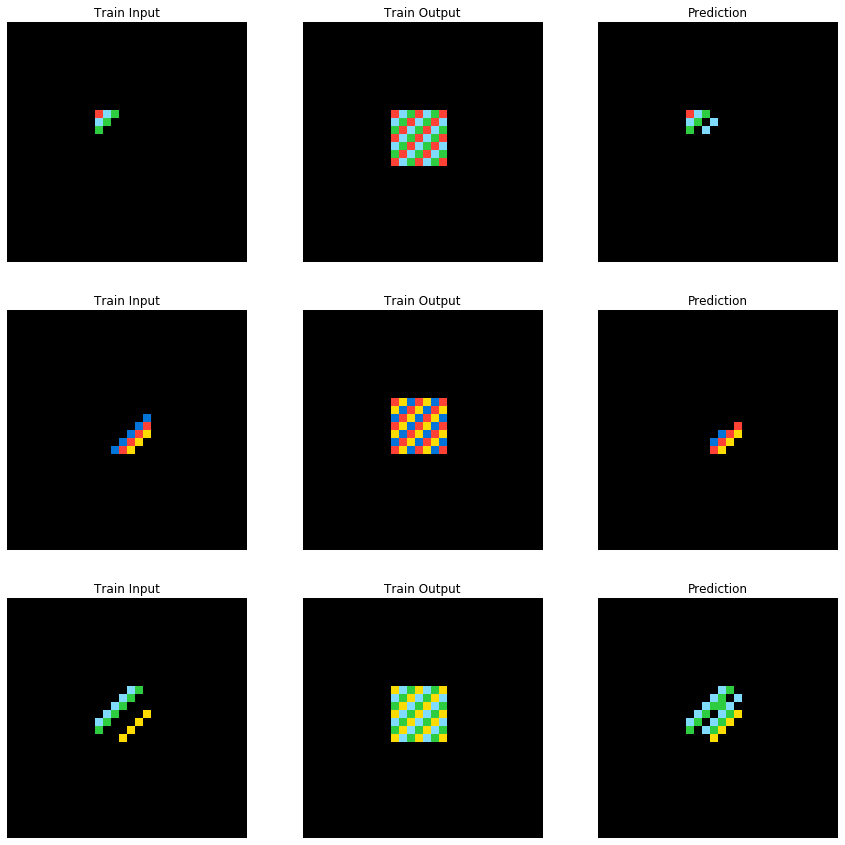

Iteration: 0, Train task: 4
Train on 3 samples
Trained
Prediction on training set MSE: 0.000925925925925926


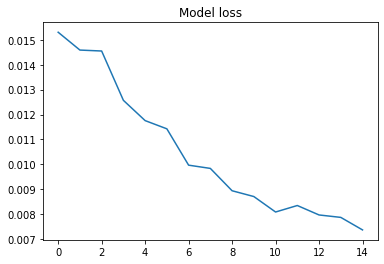

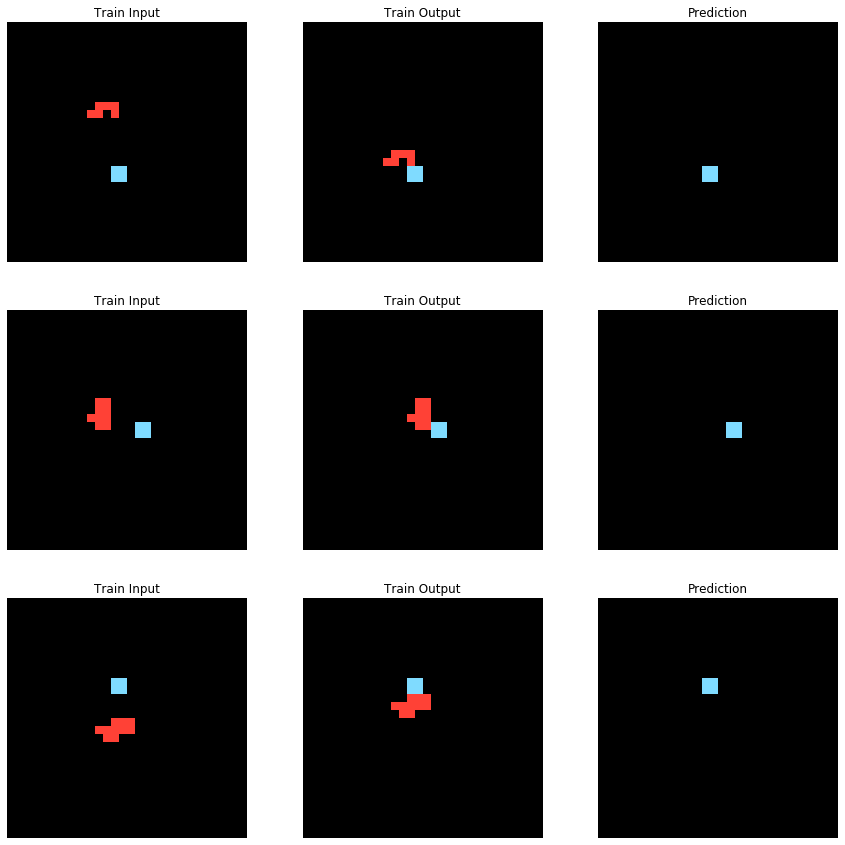

Iteration: 0, Train task: 5
Train on 3 samples
Trained
Prediction on training set MSE: 0.02914814814814815


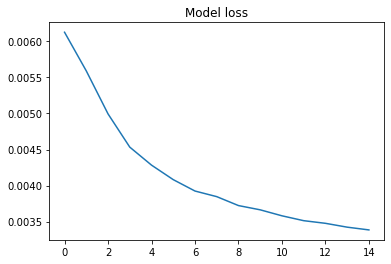

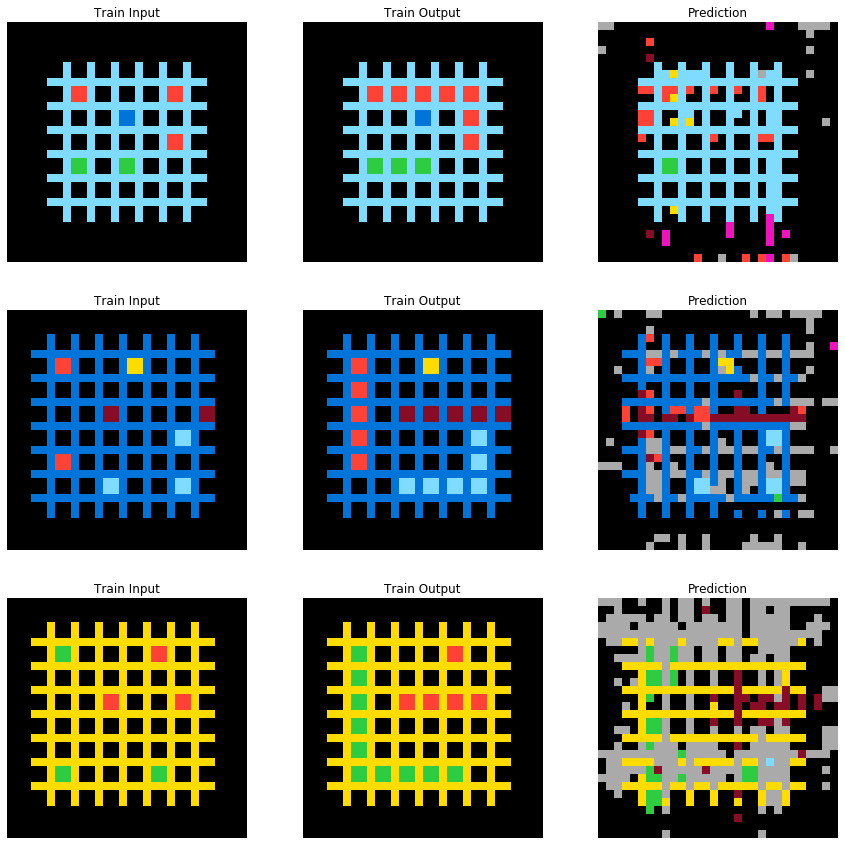

Iteration: 0, Train task: 6
Train on 2 samples
Trained
Prediction on training set MSE: 0.0023333333333333335


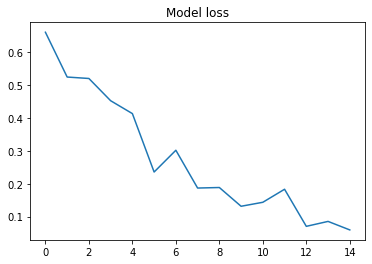

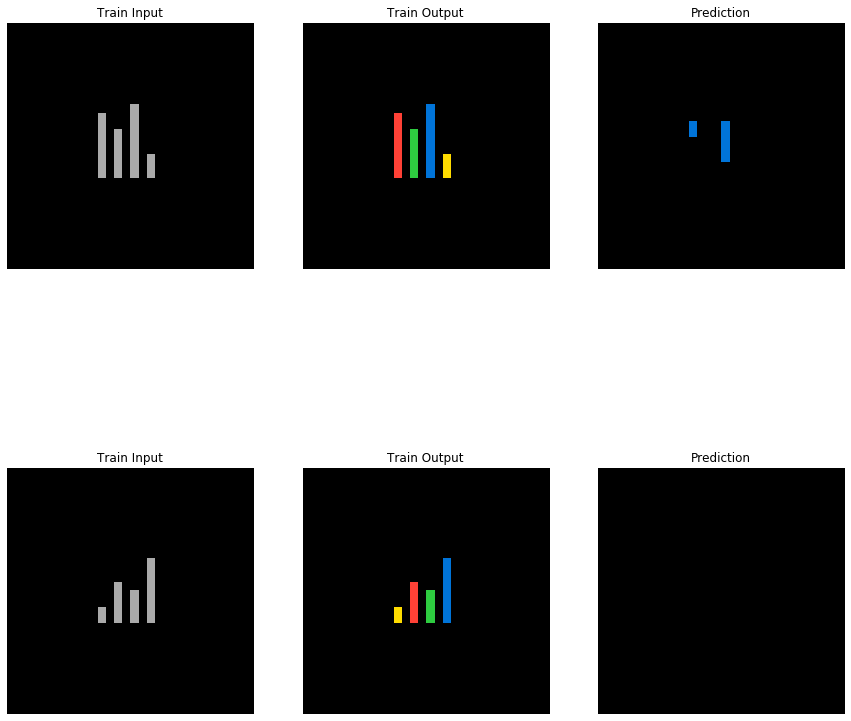

Iteration: 0, Train task: 7
Train on 4 samples
Trained
Prediction on training set MSE: 0.00575


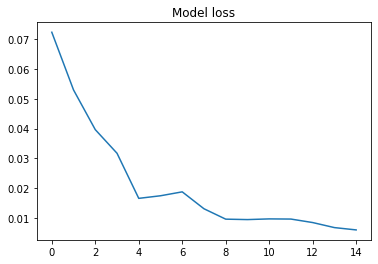

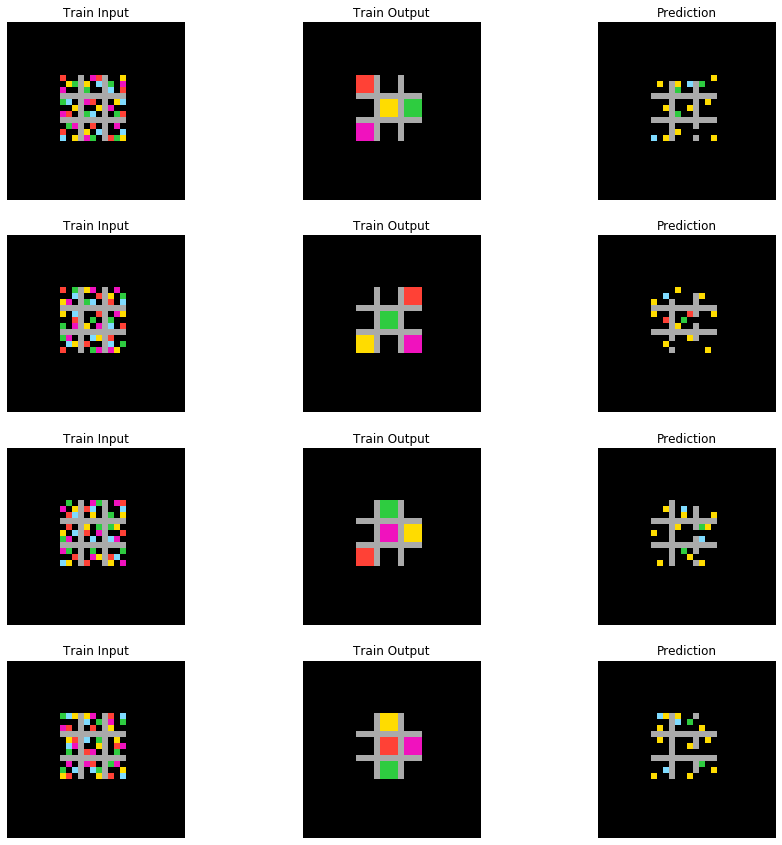

Iteration: 0, Train task: 8
Train on 2 samples
Trained
Prediction on training set MSE: 0.0033333333333333335


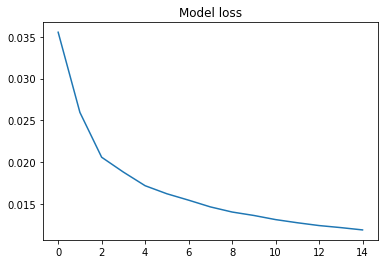

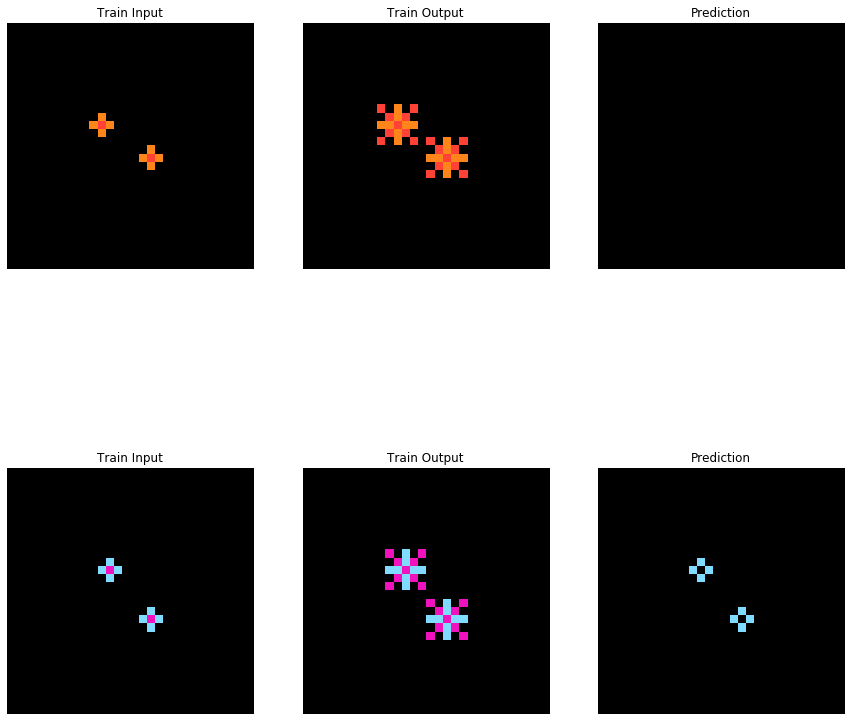

Iteration: 0, Train task: 9
Train on 4 samples
Trained
Prediction on training set MSE: 0.007138888888888889


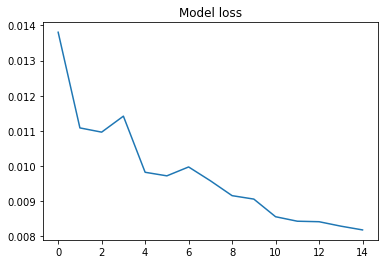

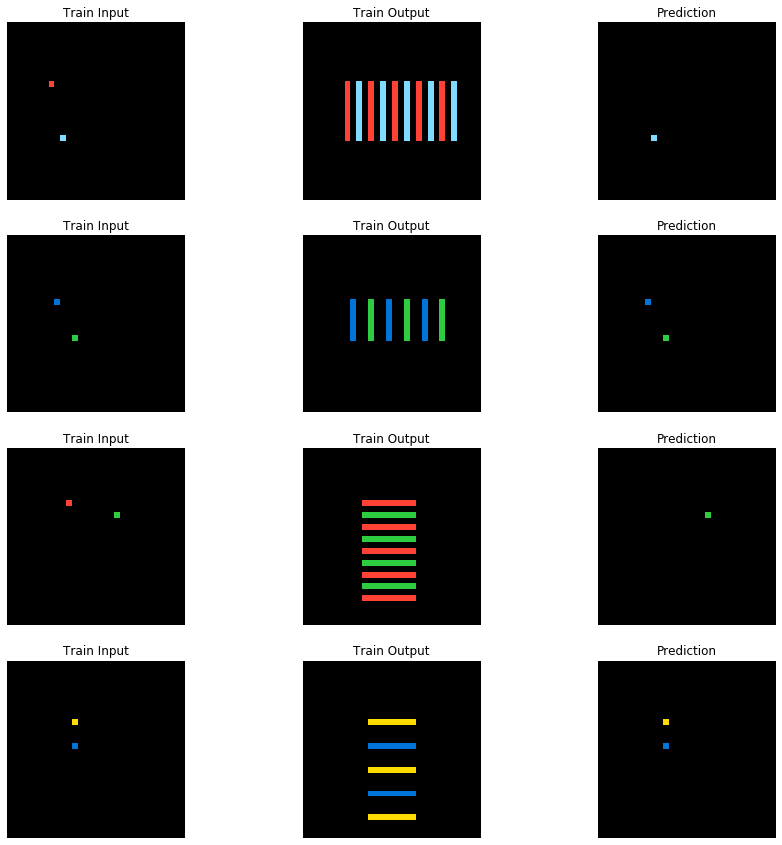

Iteration: 0, Train task: 10
Train on 3 samples
Trained
Prediction on training set MSE: 0.0015185185185185184


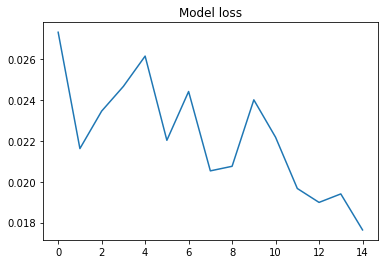

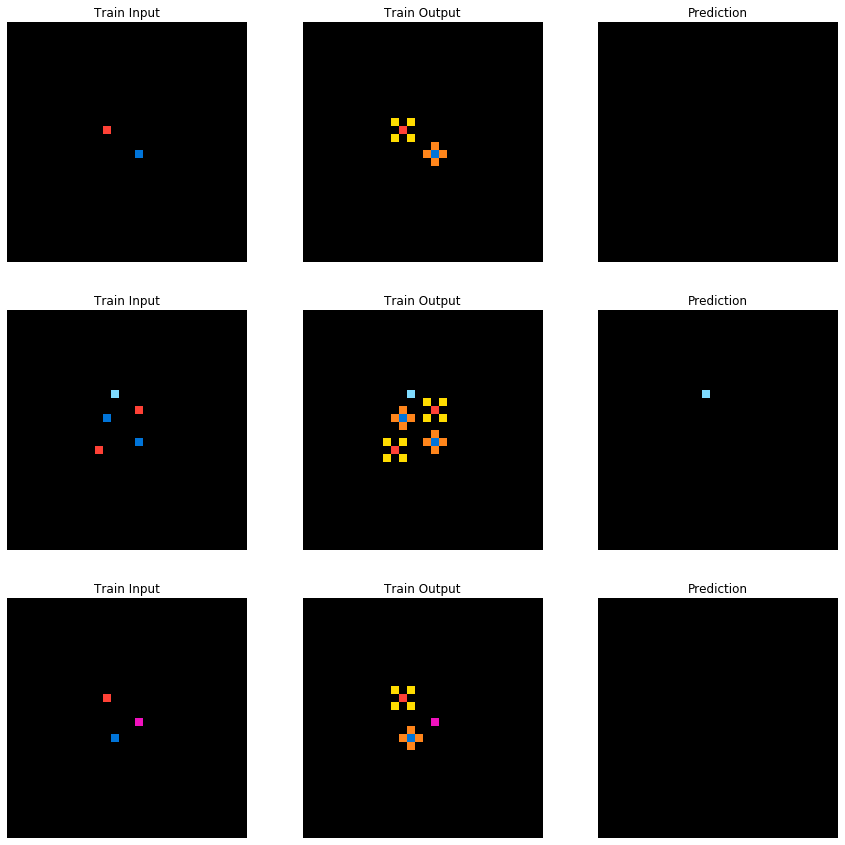

Iteration: 0, Train task: 11
Train on 4 samples
Trained
Prediction on training set MSE: 0.0011944444444444444


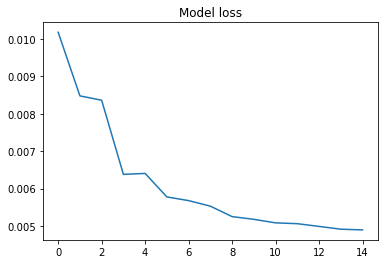

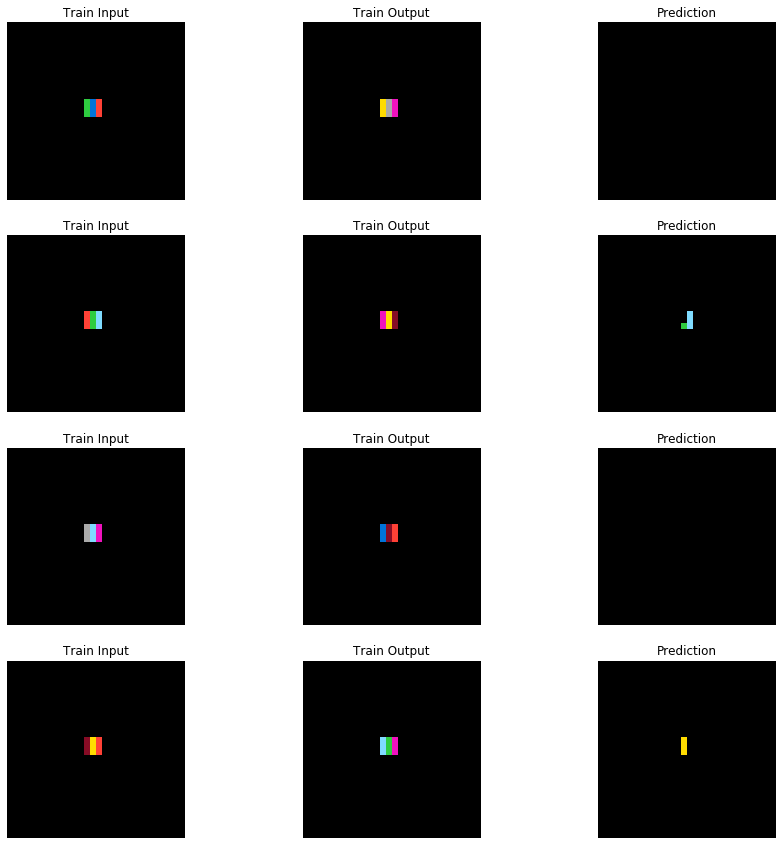

Iteration: 0, Train task: 12
Train on 3 samples
Trained
Prediction on training set MSE: 0.006333333333333333


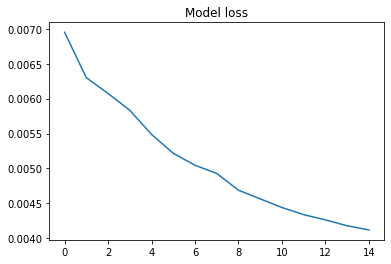

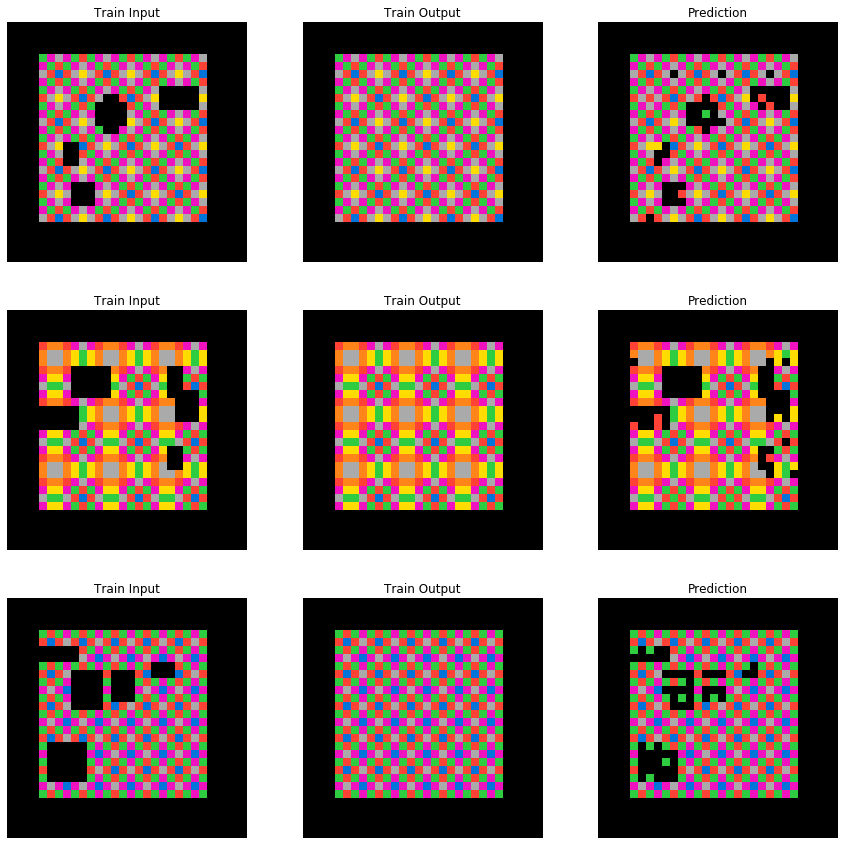

Iteration: 0, Train task: 13
Train on 3 samples
Trained
Prediction on training set MSE: 0.0022222222222222222


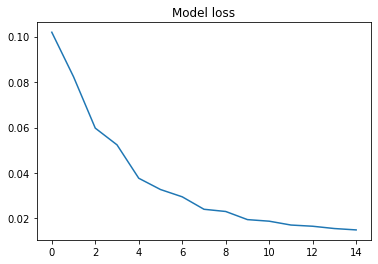

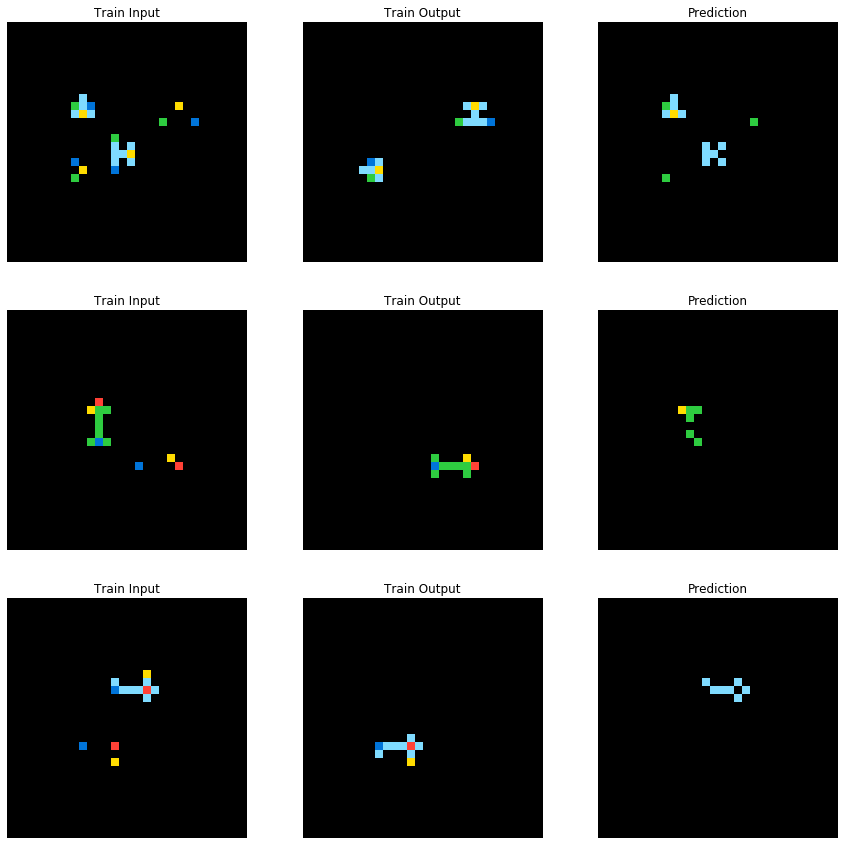

Iteration: 0, Train task: 14
Train on 3 samples
Trained
Prediction on training set MSE: 0.0005185185185185185


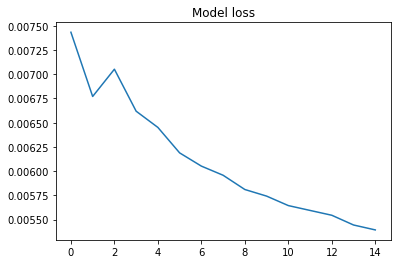

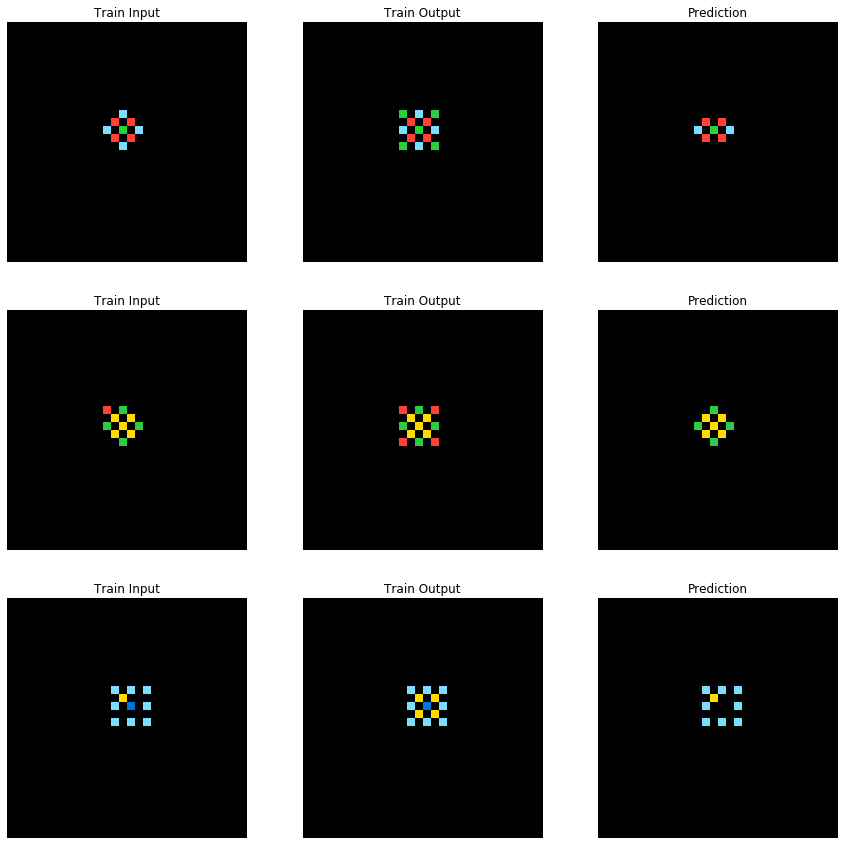

Iteration: 0, Train task: 15
Train on 3 samples
Trained
Prediction on training set MSE: 0.0024814814814814816


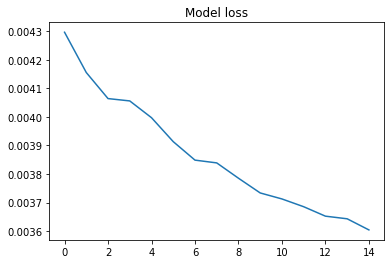

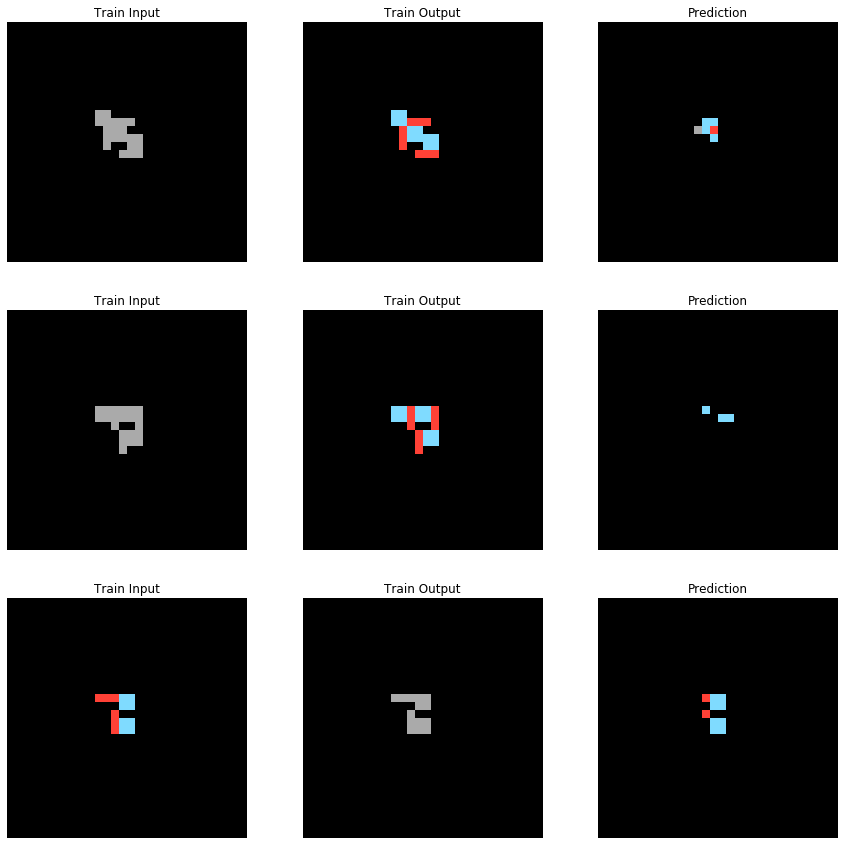

Iteration: 0, Train task: 16
Train on 3 samples
Trained
Prediction on training set MSE: 0.0033703703703703704


Iteration: 0, Train task: 17
Train on 3 samples
Trained
Prediction on training set MSE: 0.0007407407407407407


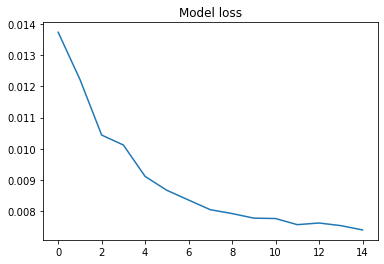

Iteration: 0, Train task: 18
Train on 3 samples
Trained
Prediction on training set MSE: 0.0011111111111111111


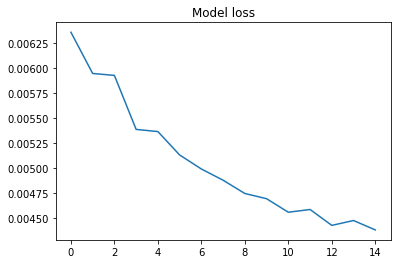

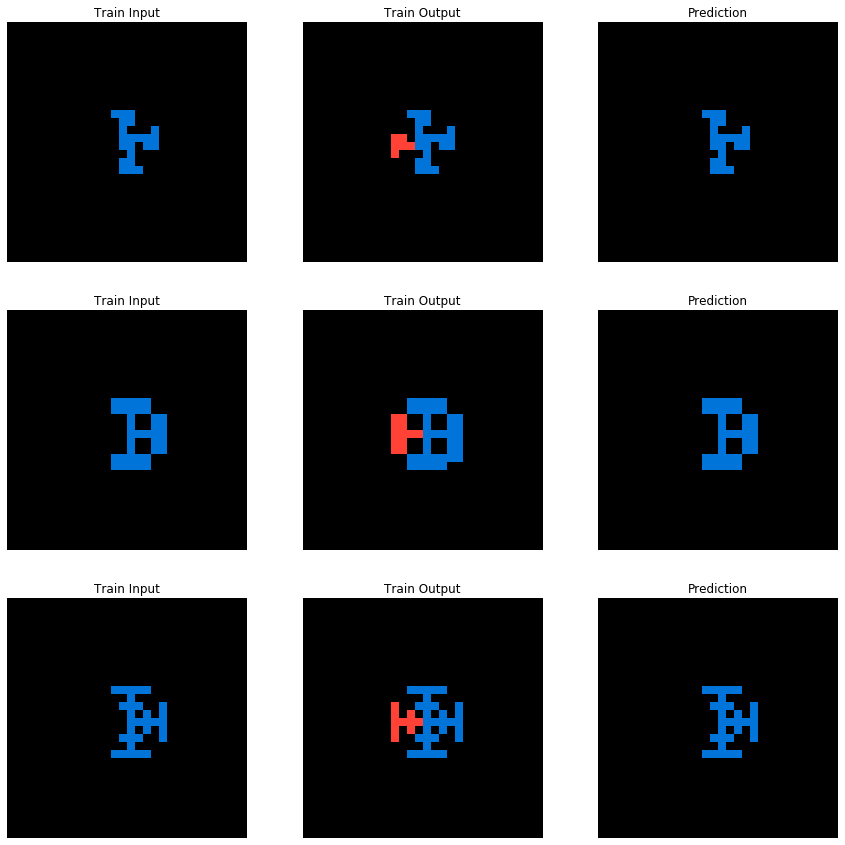

Iteration: 0, Train task: 19
Train on 2 samples
Trained
Prediction on training set MSE: 0.005555555555555556


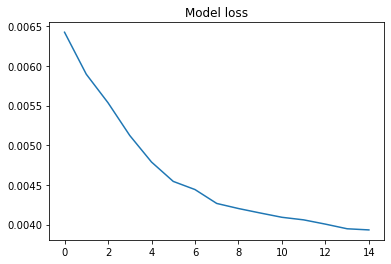

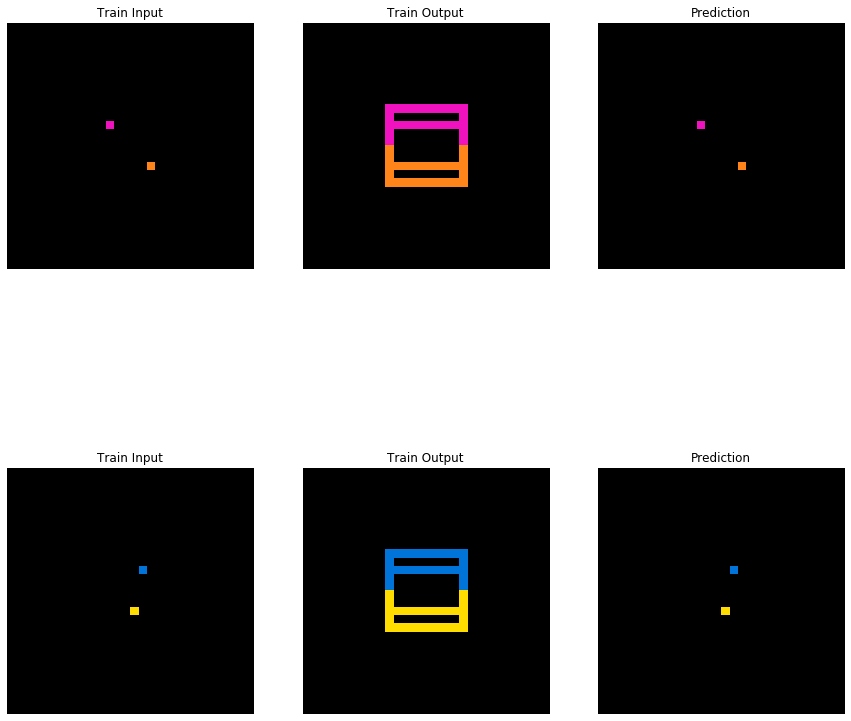

Iteration: 0, Train task: 20
Train on 3 samples
Trained
Prediction on training set MSE: 0.0012592592592592592


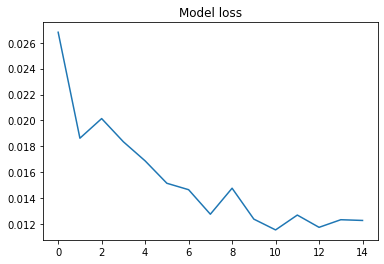

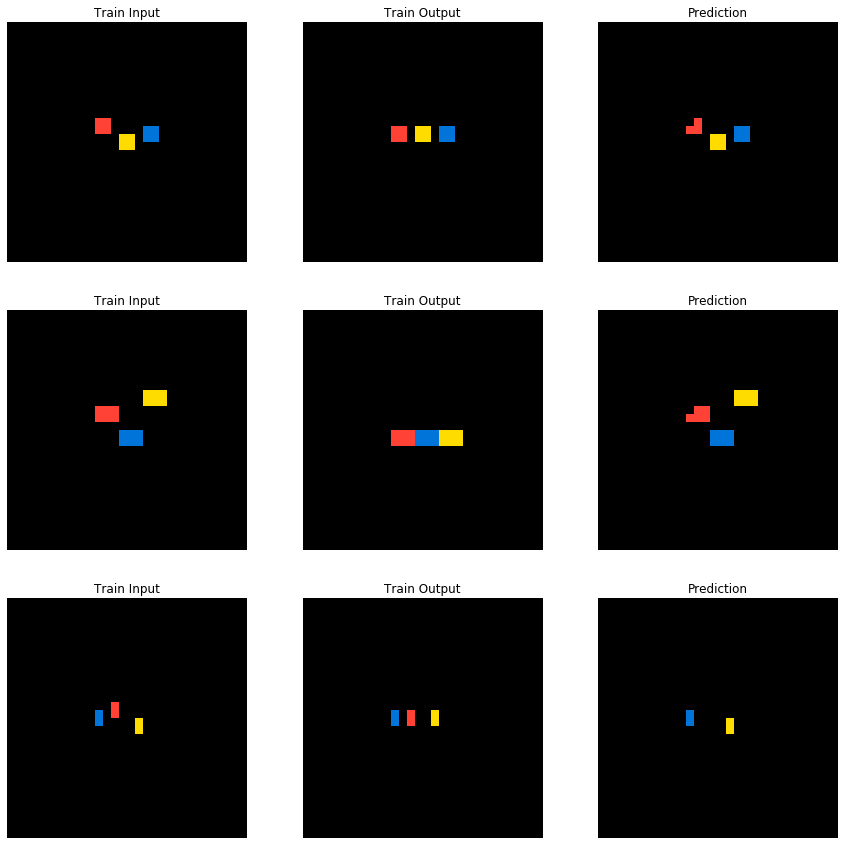

Iteration: 0, Train task: 21
Train on 3 samples
Trained
Prediction on training set MSE: 0.0006666666666666666


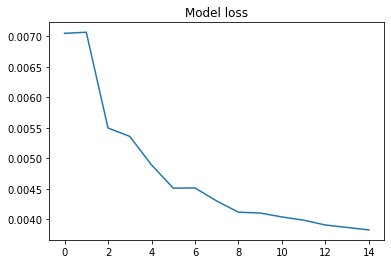

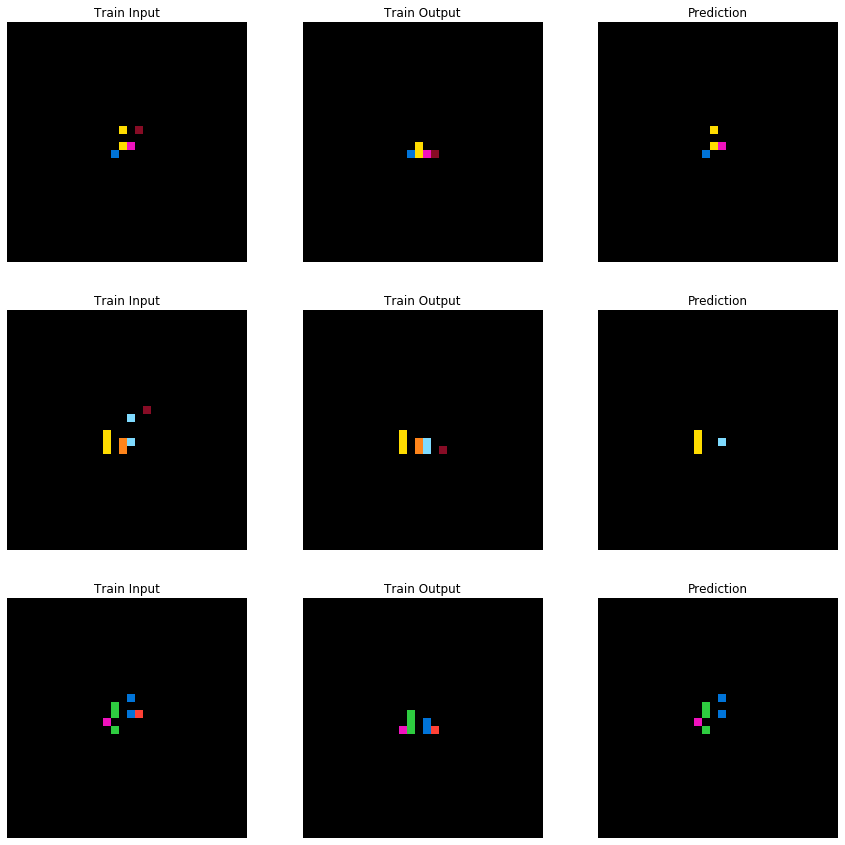

Iteration: 0, Train task: 22
Train on 3 samples
Trained
Prediction on training set MSE: 0.004407407407407408


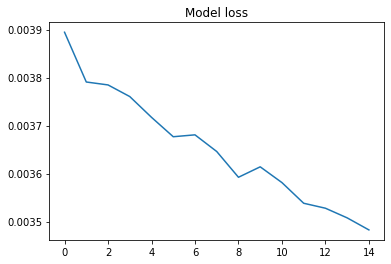

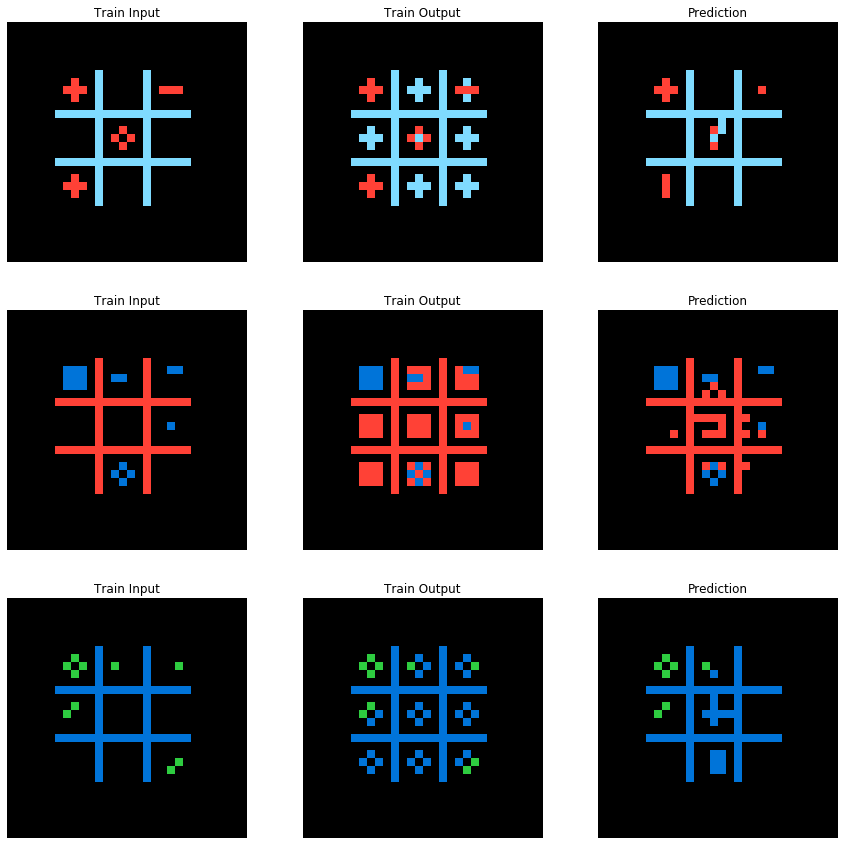

Iteration: 0, Train task: 23
Train on 4 samples
Trained
Prediction on training set MSE: 0.002361111111111111


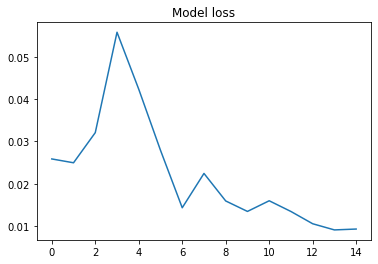

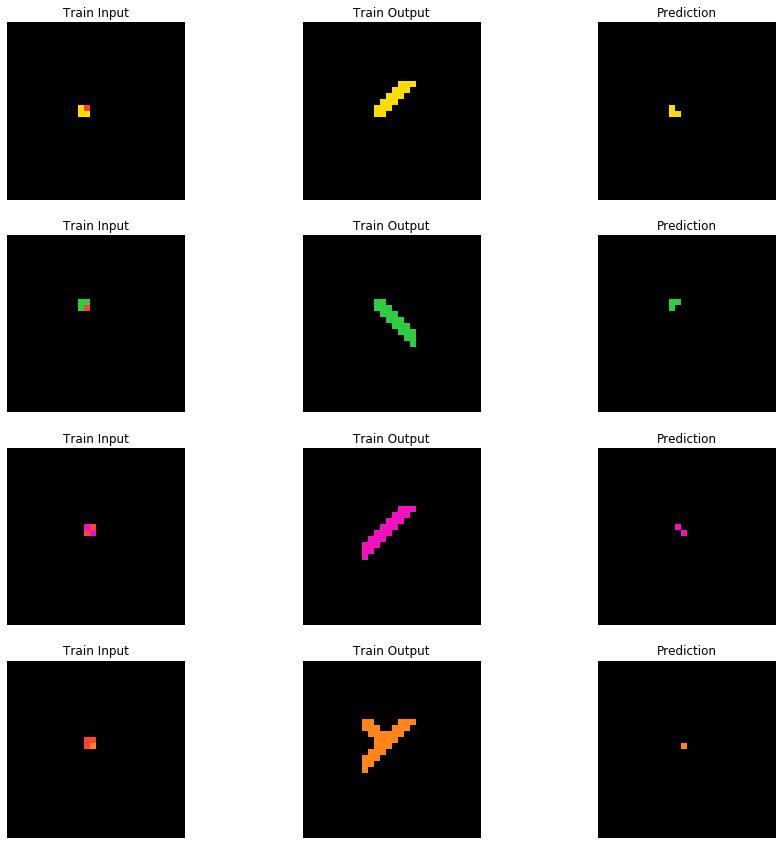

Iteration: 0, Train task: 24
Train on 3 samples
Trained
Prediction on training set MSE: 0.0011111111111111111


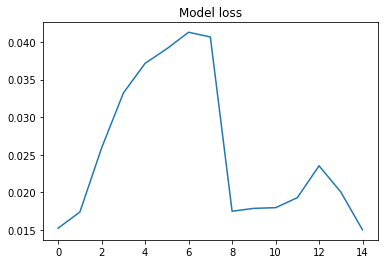

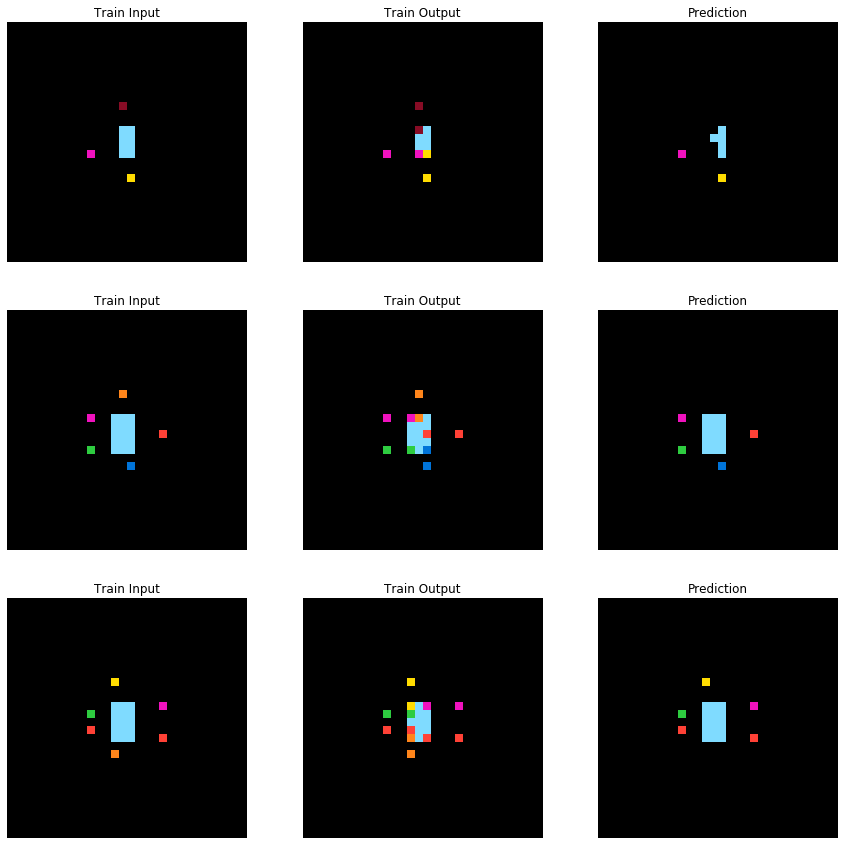

Iteration: 0, Train task: 25
Train on 3 samples
Trained
Prediction on training set MSE: 0.0012592592592592592


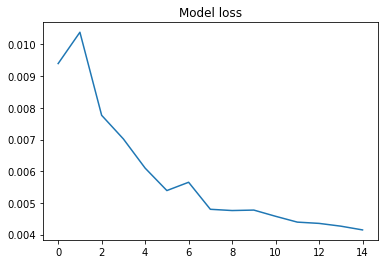

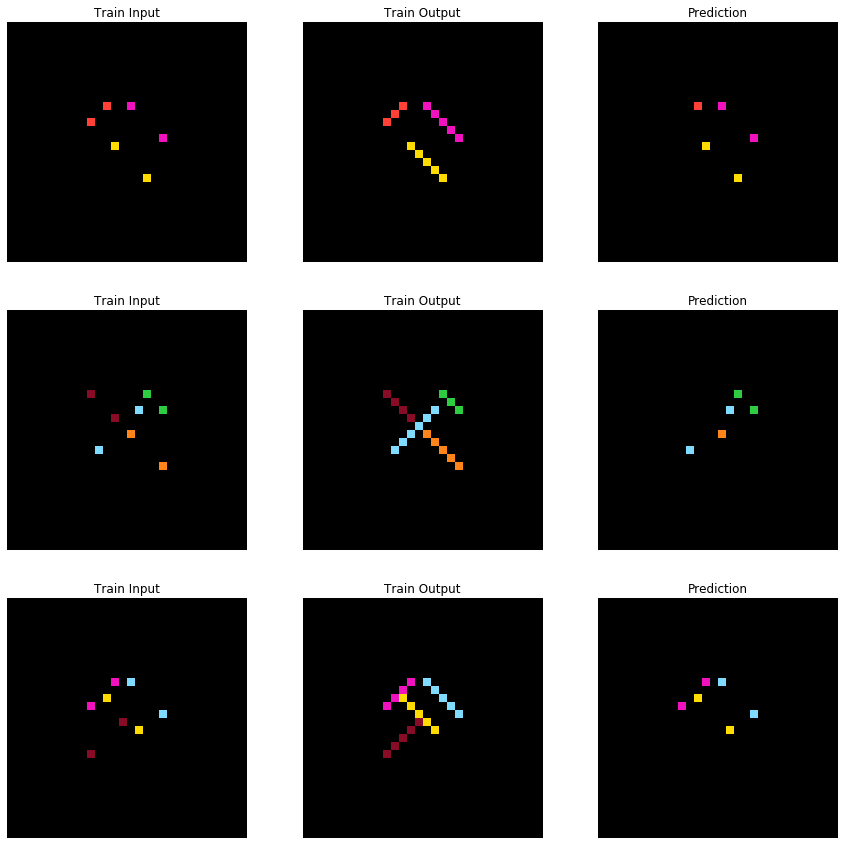

Iteration: 0, Train task: 26
Train on 3 samples
Trained
Prediction on training set MSE: 0.000925925925925926


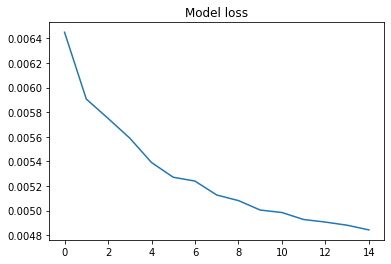

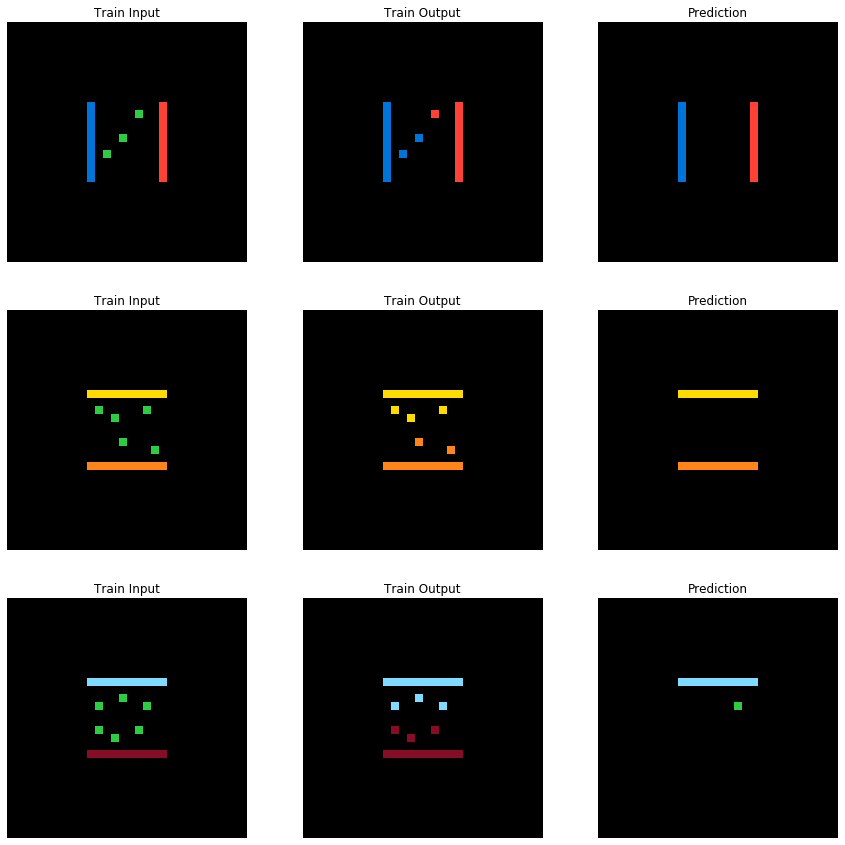

Iteration: 0, Train task: 27
Train on 3 samples
Trained
Prediction on training set MSE: 0.0015555555555555555


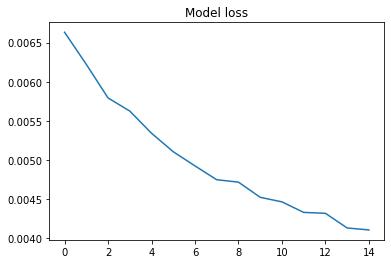

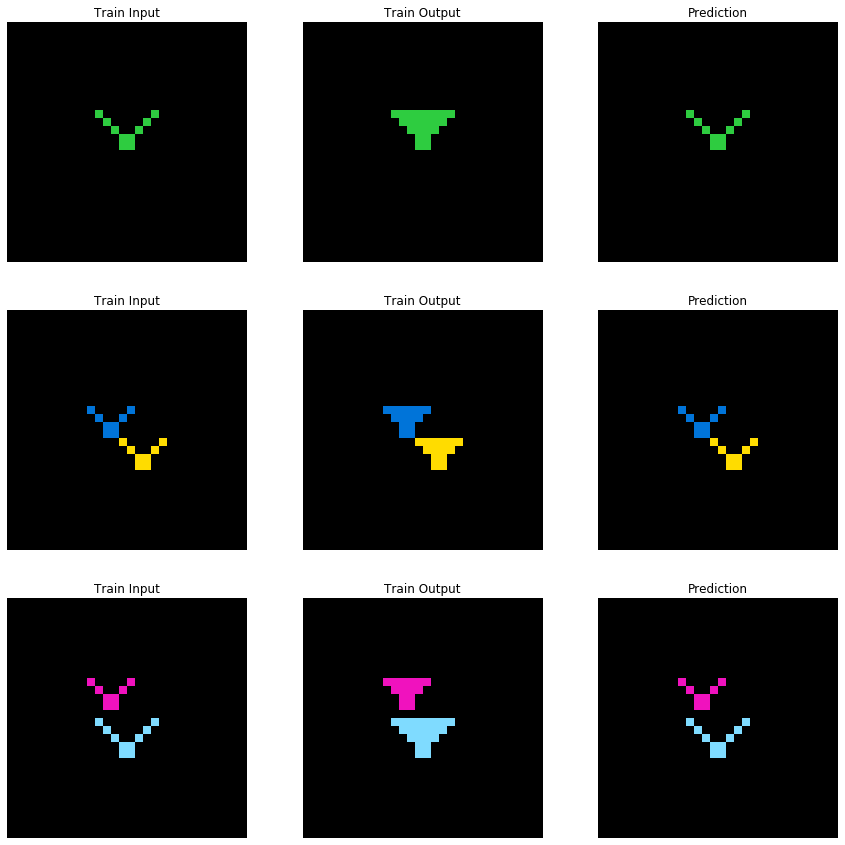

Iteration: 0, Train task: 28
Train on 3 samples
Trained
Prediction on training set MSE: 0.00044444444444444447


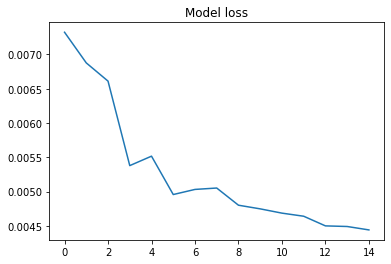

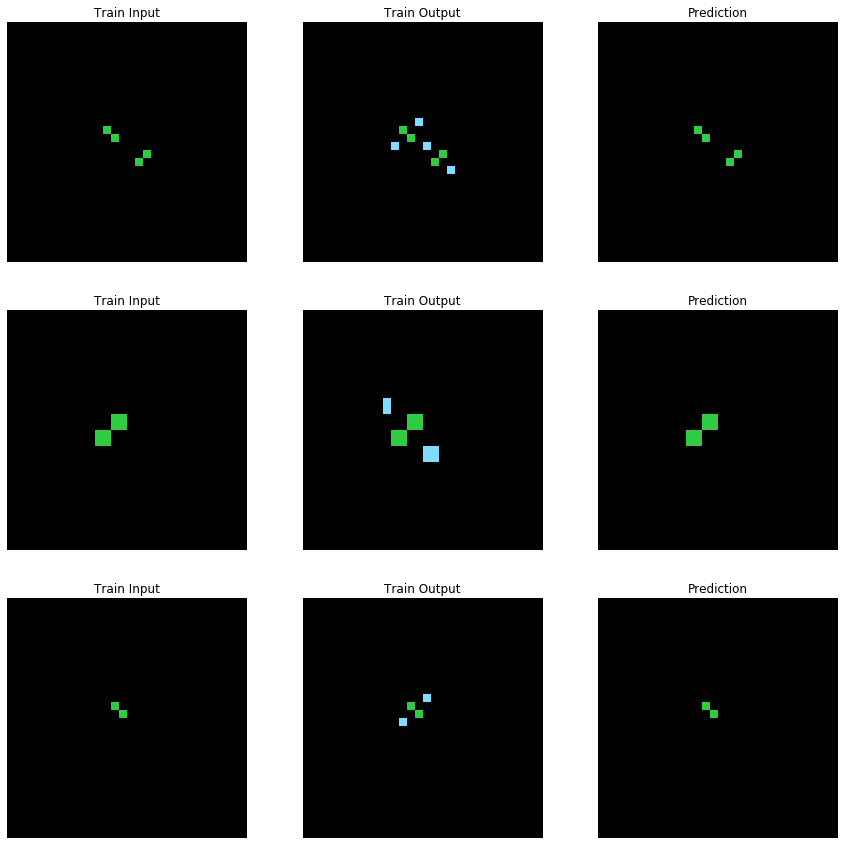

Iteration: 0, Train task: 29
Train on 3 samples
Trained
Prediction on training set MSE: 0.0014444444444444444


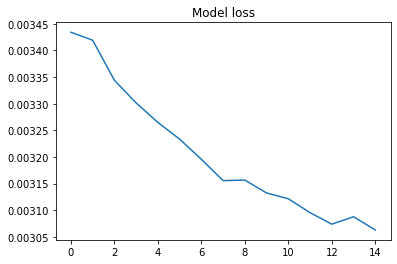

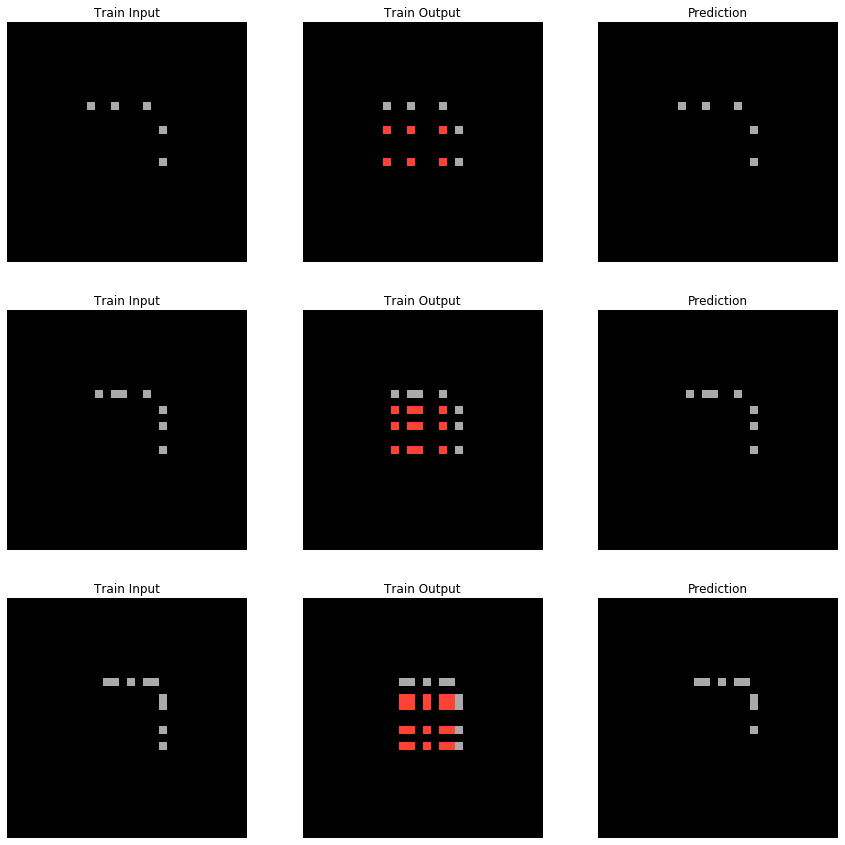

Iteration: 0, Train task: 30
Train on 3 samples
Trained
Prediction on training set MSE: 0.0015925925925925925


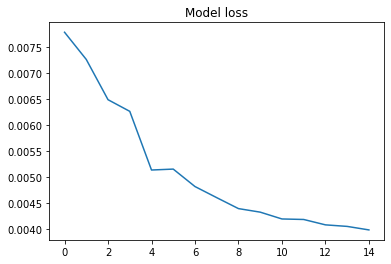

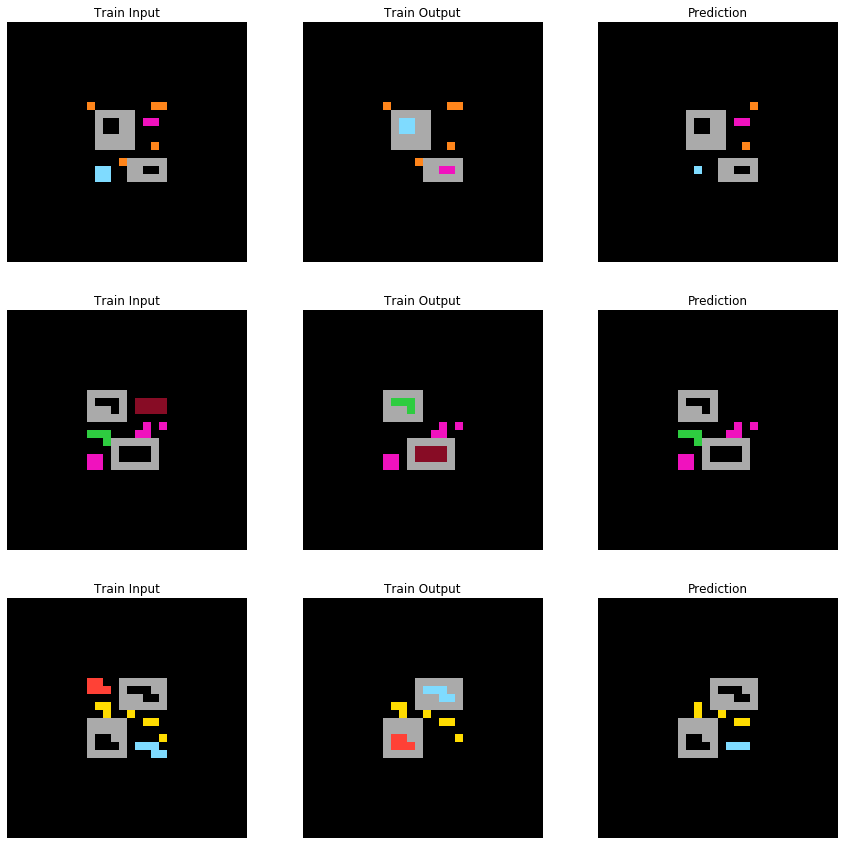

Iteration: 0, Train task: 31
Train on 3 samples
Trained
Prediction on training set MSE: 0.0011111111111111111


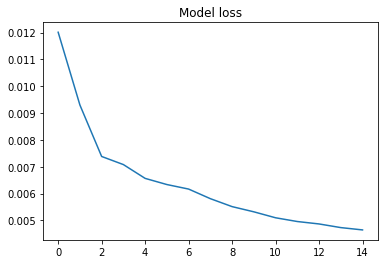

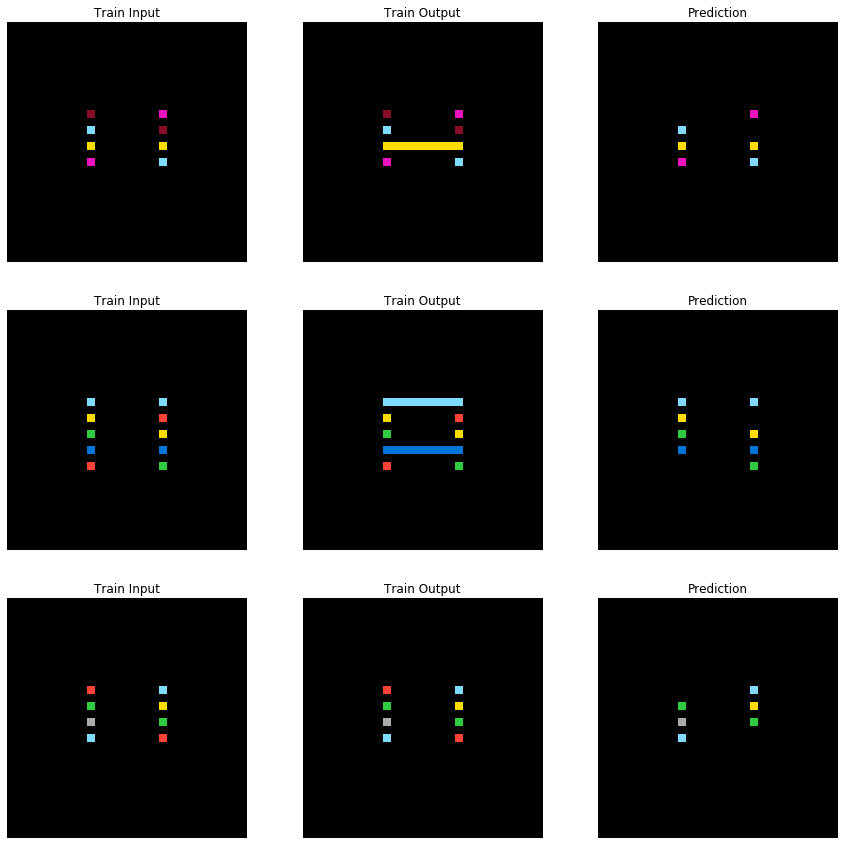

Iteration: 0, Train task: 32
Train on 2 samples
Trained
Prediction on training set MSE: 0.0033333333333333335


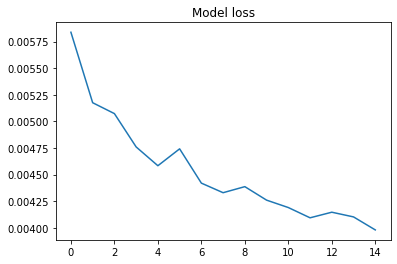

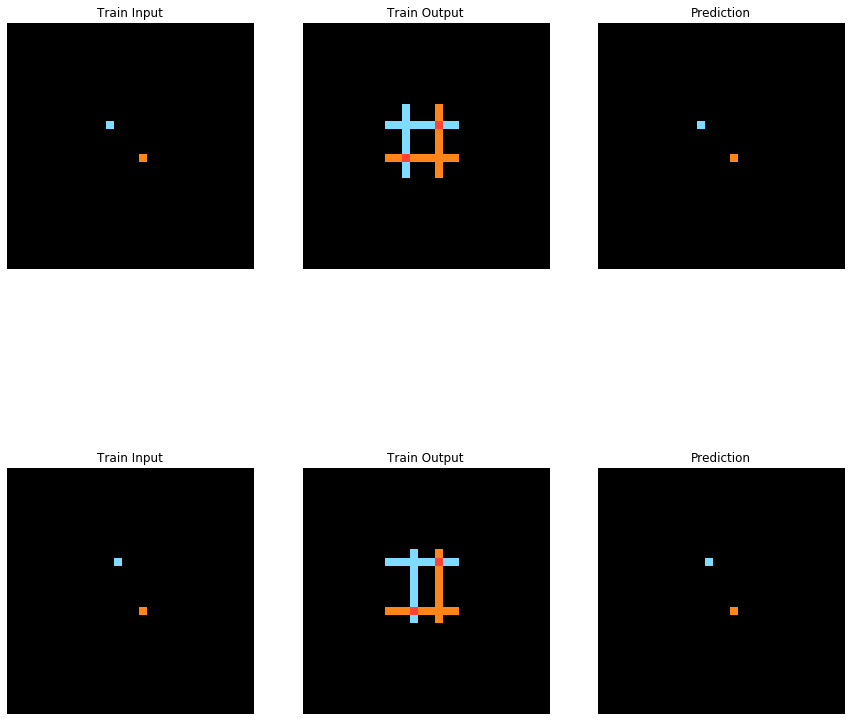

Iteration: 0, Train task: 33
Train on 8 samples
Trained
Prediction on training set MSE: 0.0006111111111111111


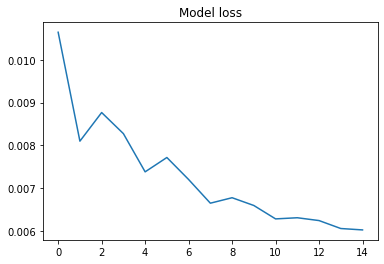

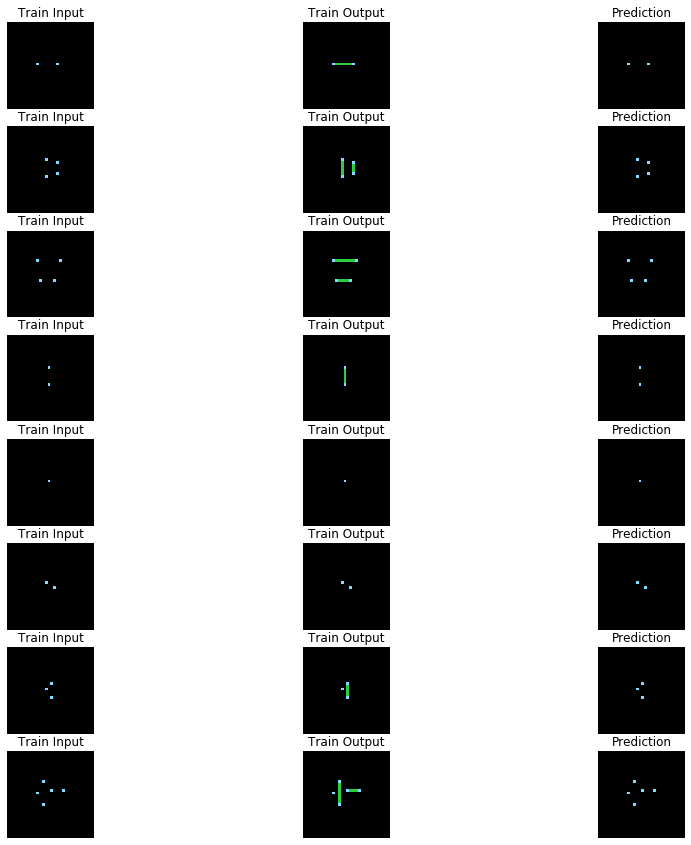

Iteration: 0, Train task: 34
Train on 3 samples
Trained
Prediction on training set MSE: 0.0008888888888888889


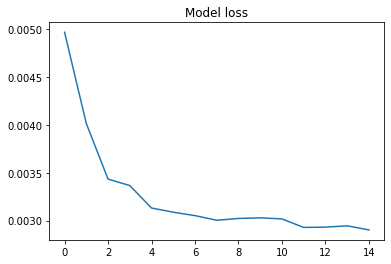

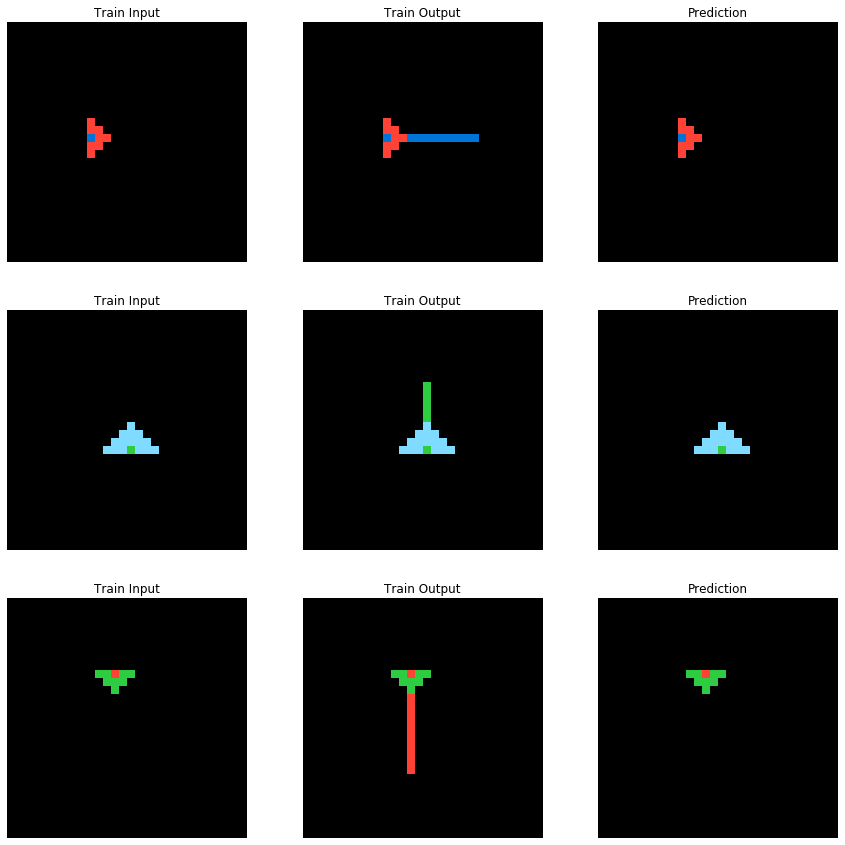

Iteration: 0, Train task: 35
Train on 4 samples
Trained
Prediction on training set MSE: 0.0006666666666666666


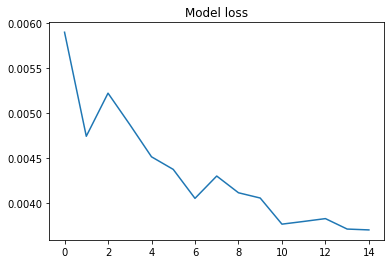

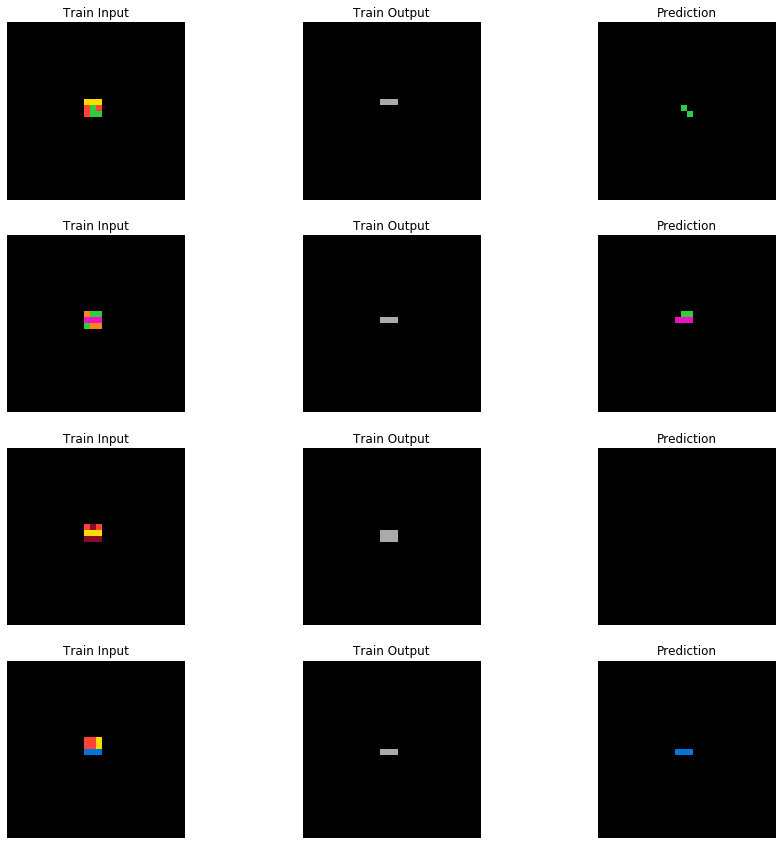

Iteration: 0, Train task: 36
Train on 4 samples
Trained
Prediction on training set MSE: 0.0005277777777777777


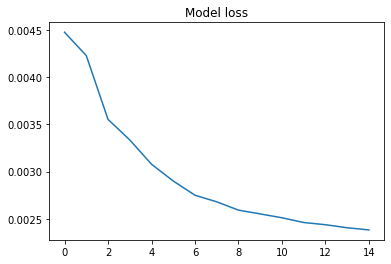

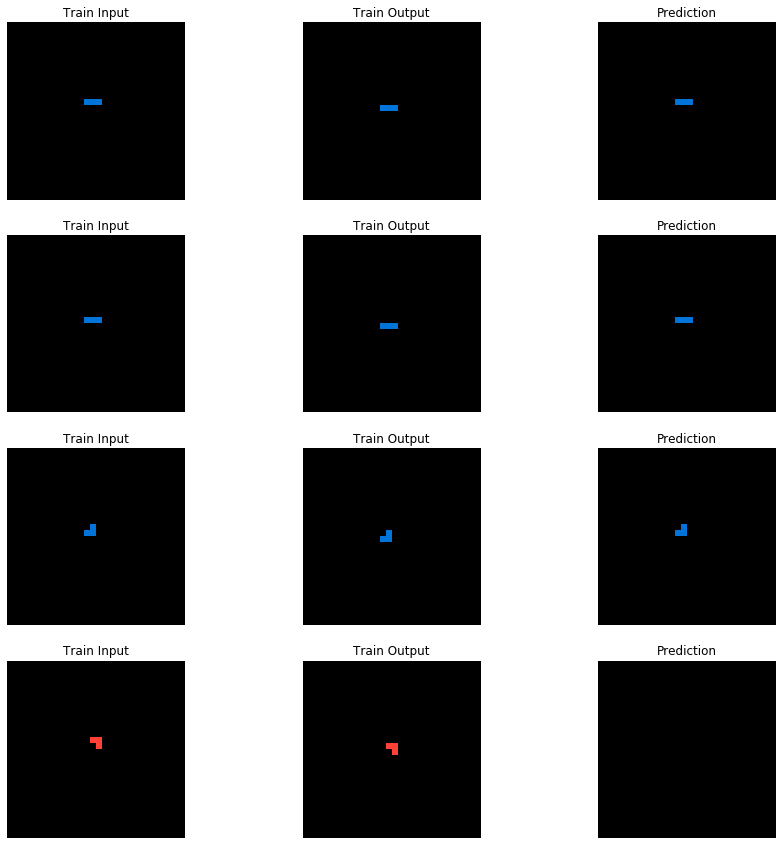

Iteration: 0, Train task: 37
Train on 3 samples
Trained
Prediction on training set MSE: 0.761


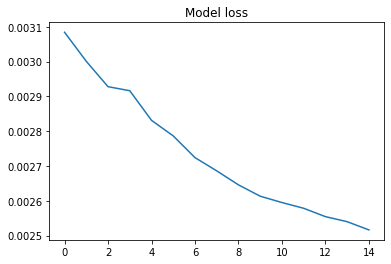

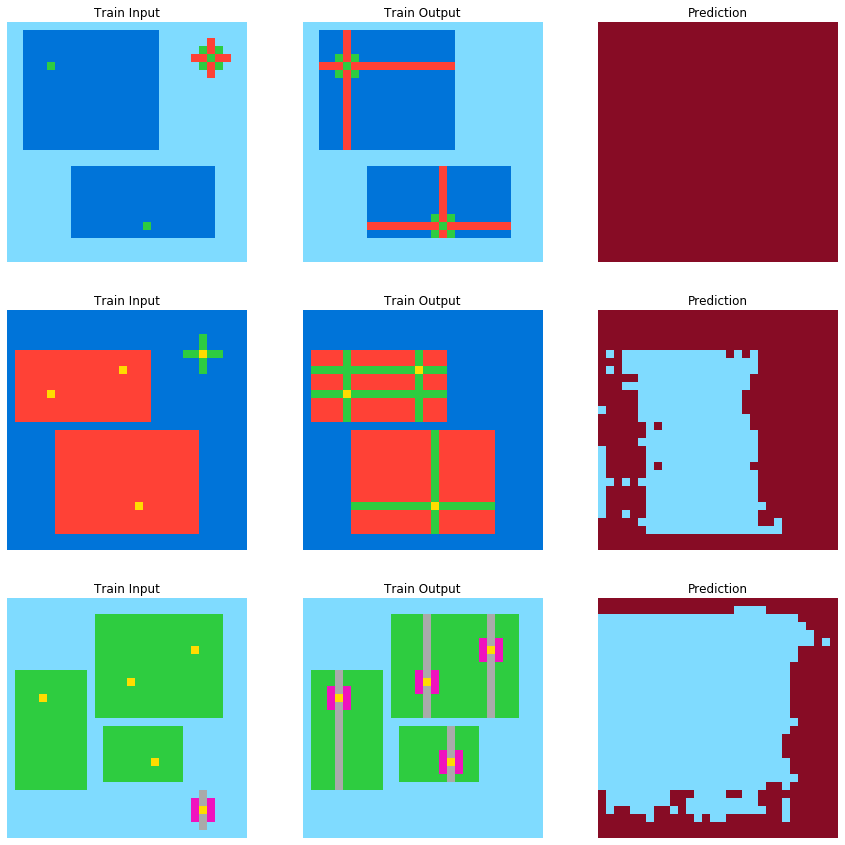

Iteration: 0, Train task: 38
Train on 2 samples
Trained
Prediction on training set MSE: 0.49066666666666664


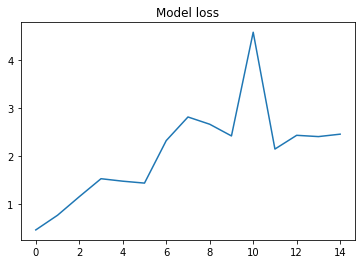

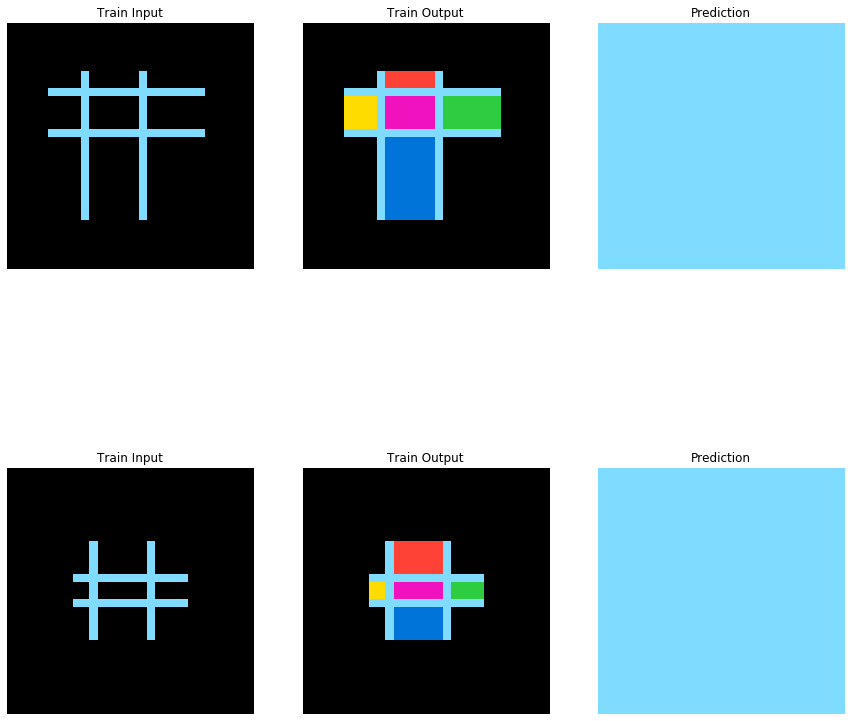

Iteration: 0, Train task: 39
Train on 5 samples
Trained
Prediction on training set MSE: 0.39226666666666665


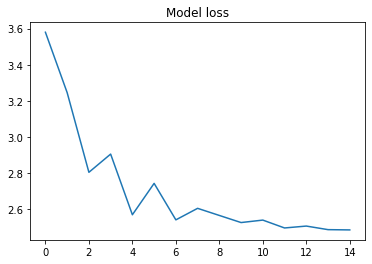

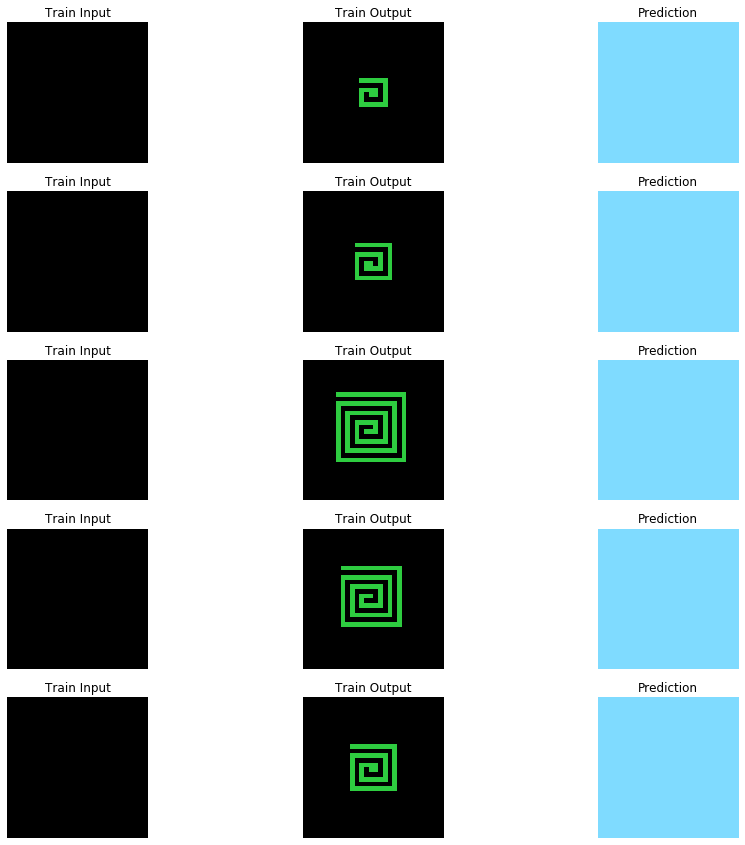

Iteration: 0, Train task: 40
Train on 3 samples
Trained
Prediction on training set MSE: 0.40014814814814814


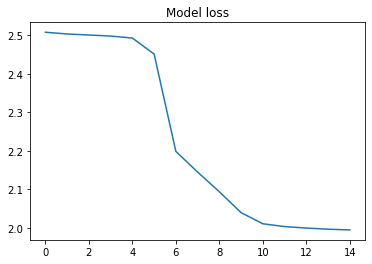

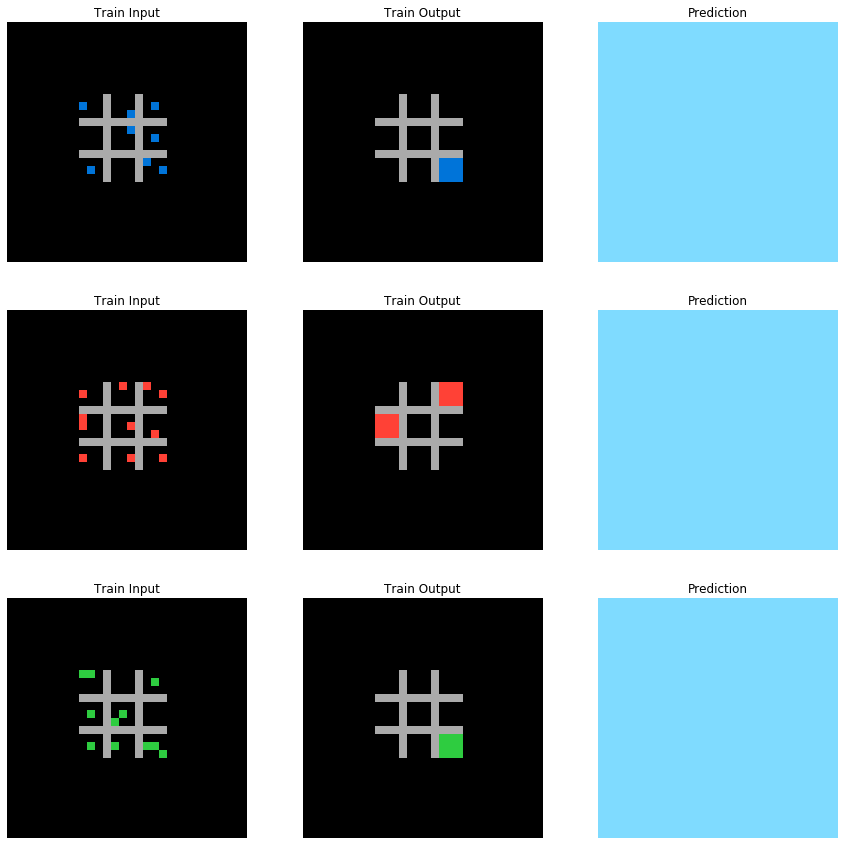

Iteration: 0, Train task: 41
Train on 2 samples
Trained
Prediction on training set MSE: 0.4007222222222222


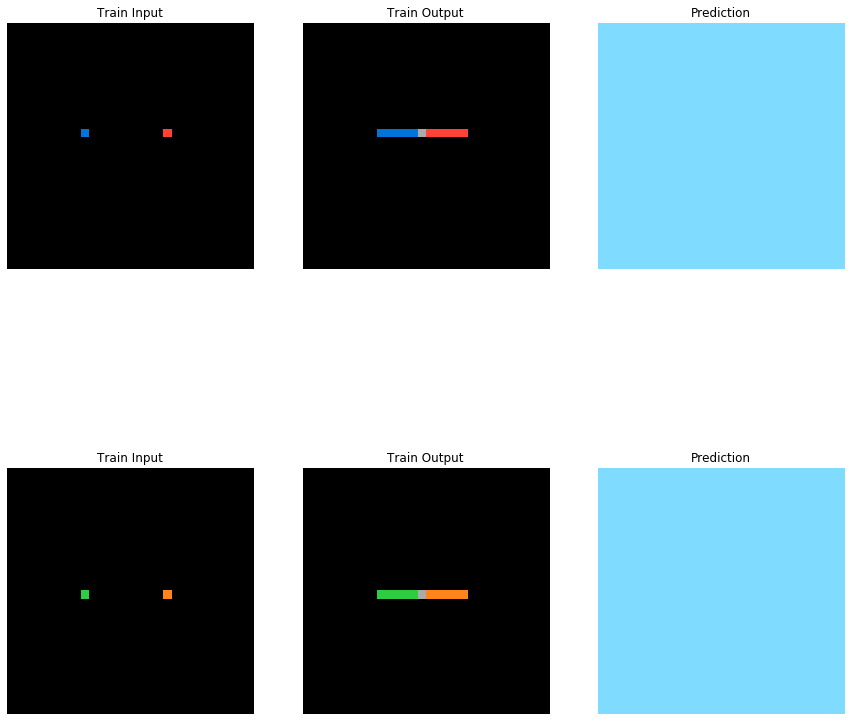

Iteration: 0, Train task: 42
Train on 4 samples
Trained
Prediction on training set MSE: 0.4007777777777778


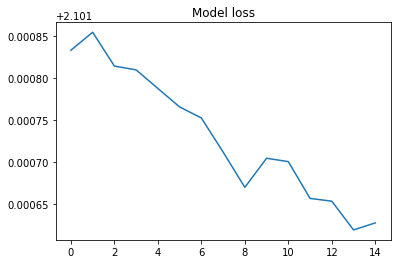

Iteration: 0, Train task: 43
Train on 4 samples
Trained
Prediction on training set MSE: 0.3903888888888889


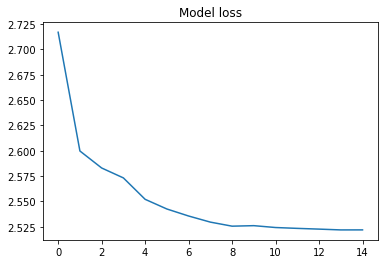

Iteration: 0, Train task: 44
Train on 3 samples
Trained
Prediction on training set MSE: 0.3888888888888889


Iteration: 0, Train task: 45
Train on 4 samples
Trained
Prediction on training set MSE: 0.39455555555555555


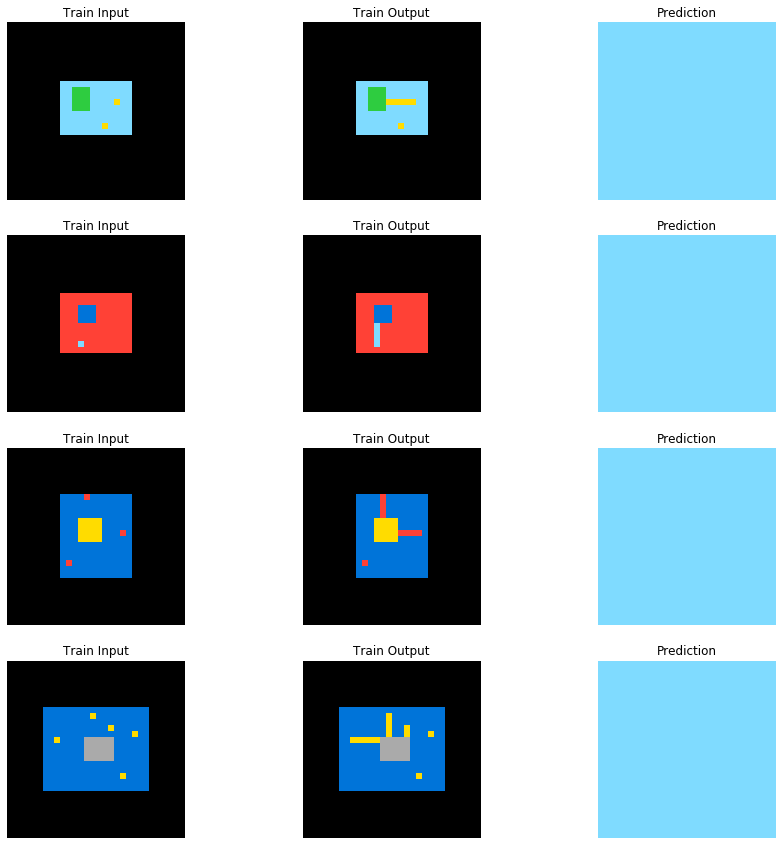

Iteration: 0, Train task: 46
Train on 3 samples
Trained
Prediction on training set MSE: 0.3907407407407407


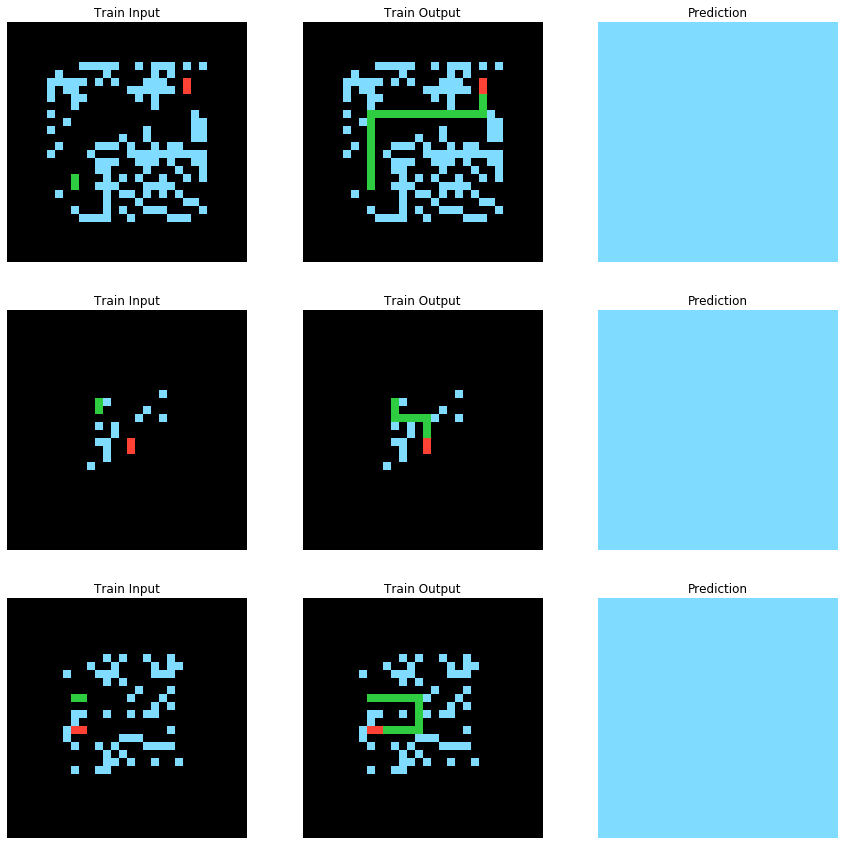

Iteration: 0, Train task: 47
Train on 3 samples
Trained
Prediction on training set MSE: 0.40014814814814814


Iteration: 0, Train task: 48
Train on 2 samples
Trained
Prediction on training set MSE: 0.4027777777777778


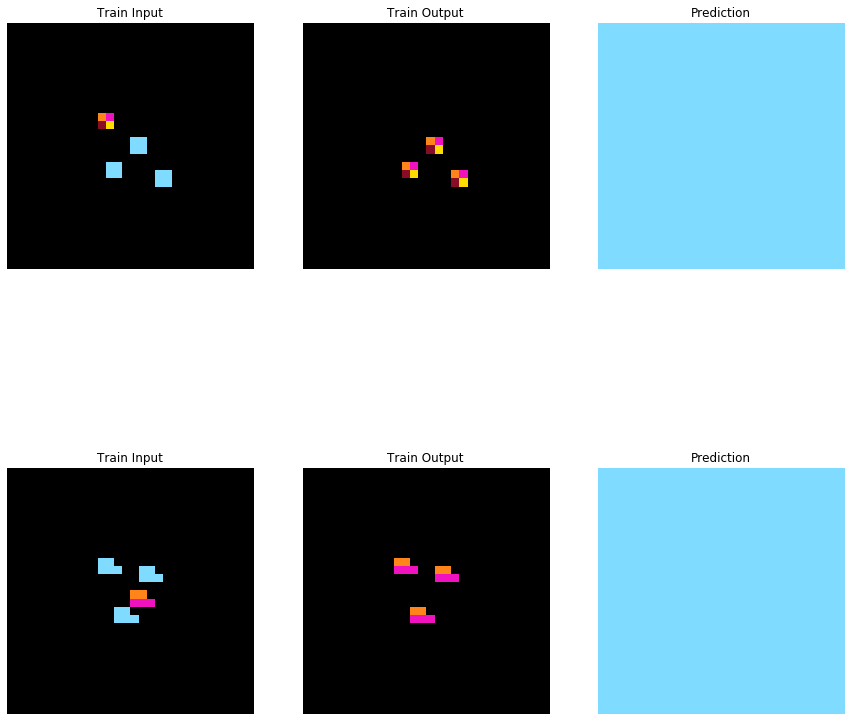

Iteration: 0, Train task: 49
Train on 3 samples
Trained
Prediction on training set MSE: 0.39840740740740743


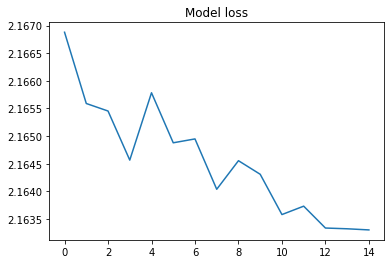

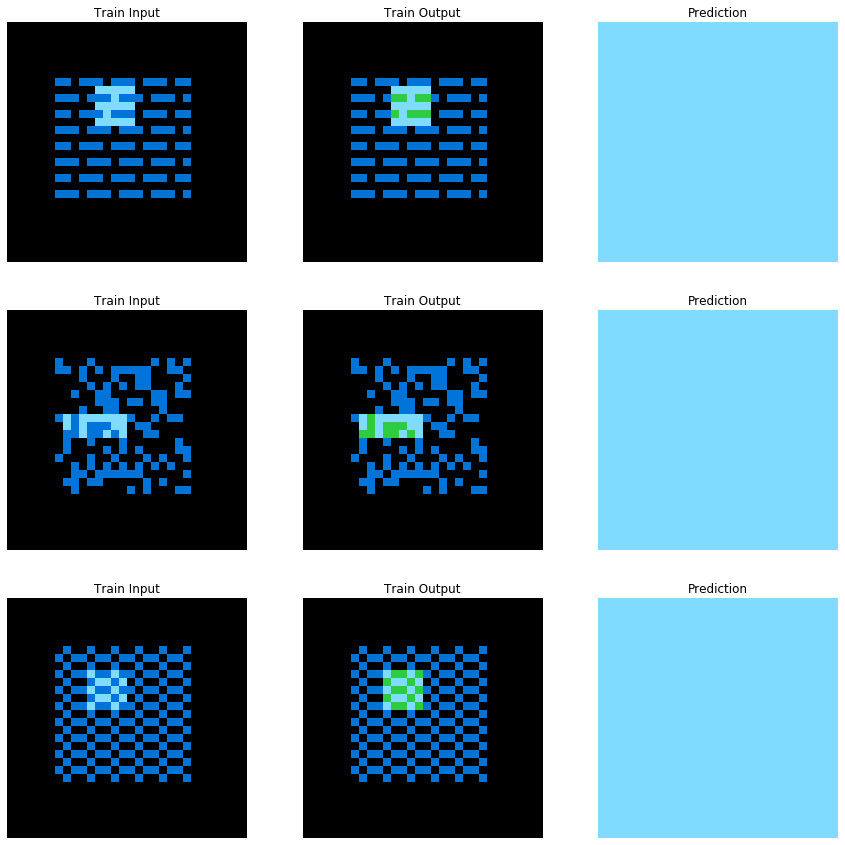

Iteration: 1, Train task: 0
Train on 5 samples


ValueError: Shapes (1, 59, 1, 2) and (1, 3, 3, 1, 64) are incompatible

In [44]:
EPOCHS = 15
ITERATIONS = 20
start = 0
nTrain = 50

model = make_model(trainTasks[0]["input"][0].shape)
model.summary()

model, history = runModel(model, trainTasks[start:start+nTrain], EPOCHS, ITERATIONS)

In [ ]:
pp_predictions.close()

In [ ]:
for layerNum, layer in enumerate(model.layers):
    if layer.name[:2] == "tb":
        print("Fixing layer:", layer.name)
        layer.trainable = False

In [ ]:
def runPretrainedModel(model, trainTasks, testTasks, EPOCHS, INIT_LR):

    def lr_scheduler(epoch):
        return INIT_LR * 0.95 ** epoch
    
    for j, task in enumerate(trainTasks):
        print("Train on {} samples".format(len(task["input"])))
        
        history = model.fit(
            np.array(task["input"]), np.array(task["output"]),
            validation_data = [np.array(task["input"]), np.array(task["output"])],
            batch_size=1,
            epochs=EPOCHS,
            callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler)],
            verbose=1
        )

        predictionRaw = model.predict(np.array(task["input"]))
        prediction = np.round(predictionRaw).astype(int)
        
        predictionRaw = model.predict(np.array(testTasks[j]["input"]))
        predictionTest = np.round(predictionRaw).astype(int)
        
        diff = np.abs(prediction - task["output"])
        mse = np.mean(np.power(diff,2))
        print("Prediction on training set MSE: {}".format(mse))
        if np.sum(prediction) == 0:
            print("All Black...")    

        input_reduced = np.swapaxes(task["input"], 1, 3)
        input_reduced = np.array([reduceColors(xi) for xi in input_reduced])
        output_reduced = np.swapaxes(task["output"], 1, 3)
        output_reduced = np.array([reduceColors(xi) for xi in output_reduced])
        prediction = np.swapaxes(prediction, 1, 3)
        prediction = np.array([reduceColors(xi) for xi in prediction])        

        inputTest_reduced = np.swapaxes(testTasks[j]["input"], 1, 3)
        inputTest_reduced = np.array([reduceColors(xi) for xi in inputTest_reduced])
        outputTest_reduced = np.swapaxes(testTasks[j]["output"], 1, 3)
        outputTest_reduced = np.array([reduceColors(xi) for xi in outputTest_reduced])
        predictionTest = np.swapaxes(predictionTest, 1, 3)
        predictionTest = np.array([reduceColors(xi) for xi in predictionTest])


        cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
            '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        norm = colors.Normalize(vmin=0, vmax=9)

        fig, axs = plt.subplots(len(input_reduced)+1, 3, figsize=(15,15))

        for k, inp, out, pred in zip(np.arange(len(input_reduced)), input_reduced, output_reduced, prediction):


            axs[k][0].imshow(inp, cmap=cmap, norm=norm)
            axs[k][0].axis('off')
            axs[k][0].set_title('Train Input')

            axs[k][1].imshow(out, cmap=cmap, norm=norm)
            axs[k][1].axis('off')
            axs[k][1].set_title('Train Output')

            axs[k][2].imshow(pred, cmap=cmap, norm=norm)
            axs[k][2].axis('off')
            axs[k][2].set_title('Prediction')

        axs[k+1][0].imshow(inputTest_reduced[0], cmap=cmap, norm=norm)
        axs[k+1][0].axis('off')
        axs[k+1][0].set_title('Test Input')

        axs[k+1][1].imshow(outputTest_reduced[0], cmap=cmap, norm=norm)
        axs[k+1][1].axis('off')
        axs[k+1][1].set_title('Test Output')

        axs[k+1][2].imshow(predictionTest[0], cmap=cmap, norm=norm)
        axs[k+1][2].axis('off')
        axs[k+1][2].set_title('Prediction')
            
            
        pp_predictions.savefig()
        plt.show()

            
    return model, history

In [ ]:
pp_predictions = PdfPages('checkTest.pdf')

In [ ]:
pretrainedWeights = model.get_weights()

In [ ]:
INIT_LR = 0.001
optimizer = keras.optimizers.adam(learning_rate=INIT_LR)

model.compile(
    loss=expoLoss,
    #loss="mean_squared_error",
    #loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

In [ ]:
model.set_weights(pretrainedWeights)

In [ ]:
EPOCHS = 100
start = 0
nTrain = 50

model_fixed, history_fixed = runPretrainedModel(model, trainTasks[start:start+nTrain], testTasks[start:start+nTrain], EPOCHS, INIT_LR)

In [ ]:
pp_predictions.close()